# <span style="color: royalblue;">Introduction to Deep Learning - Final Project</span>

<span style="font-size: 18px; font-weight: bold; color: royalblue;">Classifying Digits From EEG Brain Signals</span>

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Author: David Weber, 2025 Summer 1 Session</span>

<span style="font-size: 16px; font-weight: bold; color: royalblue;">Introduction:</span>

For my **Introduction to Deep Learning** final project, I took inspiration from an article I read in my **Ethical Issues in Computing Applications** class. The article centered on the use of brain-computer interfaces such as Neuralink, but it also mentioned that researchers were looking into non-invasive forms of brain-computer interfaces. I believe artificial intelligence will greatly benefit humanity through medical technology advances, so I wanted to do a final project related to a brain interaction using EEG data.

In my research I came across a site of titled **The "MNIST" of Brain Digits** where data was collected from a subject who was shown a digit and thought about it for about 2 seconds. This seemed like a perfect topic to do a final project on. The site has 4 different datasets, one of which was from using the **EPOC X - 14 Channel Wireless EEG Headset**. I chose this dataset because the device has the most channels compared to the other devices.

The data is from a large number of events with a comma separated set of values representing time-series amplitudes of the signal. This data is collected across 14 different channels, each collecting neural activity from different areas of the brain.

My goal with this project is to use this data to predict which digit the subject was shown (and thought) about. Because of how the data is structured, I believe using both convolutional neural networks (**CNN**) and recurrent neural networks (**RNN**) will be beneficial.

<span style="font-size: 16px; font-weight: bold; color: red;">Challenges:</span>
* The data is collected from a single subject.
* The data is noisy, as the brain has constant activity. Separating out the desired signals will likely be difficult. There is also no way of knowing what the brain is thinking about, and the areas being recorded may not have anything to do with the thoughts intended in this study. From the article **Deep Recurrent Neural Networks for Electroencephalography Analysis** it states "...it's prone to high levels of noise and an inaccurate signal."
* It will be a challenge to learn meaningful patterns as the signals will likely be subtle.

I don't expect to get very high accuracy numbers with this data, but that isn't the goal of this project. The main goal of this project is to learn about emergent technologies in the field of AI. That said, I do expect to predict digits from EEG data at a statistically significant level above random chance.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">The EPOC-X 14 channel EEG wireless headset used to gather data for this project:</span>

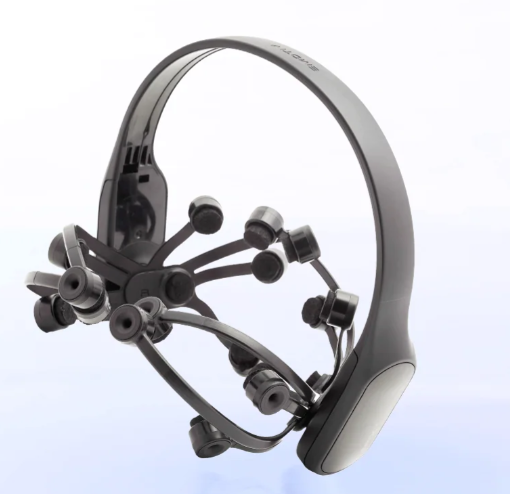

<span style="font-size: 15px; font-weight: bold;">Dataset:</span>

Vivancos, D. (n.d.). MindBigData: The 'MNIST' of Brain Digits. Retrieved May 15, 2025, from https://mindbigdata.com/opendb/index.html

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Setup:</span>

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import display, HTML
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Conv1D, GRU, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, MaxPooling1D, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import Callback,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW
from keras.initializers import Orthogonal
from keras import regularizers
from abc import ABC, abstractmethod
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

%matplotlib inline

In [2]:
# SETUP
SEED_VALUE = 100
DISPLAY_FONT_SIZE = 14
TITLE_FONT_SIZE = 14

BLUE_COLOR = '#48B8D0'
GREEN_COLOR = '#2EBFA5'

# Setting various seed values
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
random.seed(SEED_VALUE)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Remove restriction on column display widths:
pd.set_option('display.max.colwidth', None)

In [3]:
# Custom function for key, value pair display
def custom_display(title, value=None):
    """
    Prints output with larger font and bold title.
    """
    display(HTML(f'<span style="font-size:{DISPLAY_FONT_SIZE}px;"><b>{title}</b>{f": {value}" if value is not None else ""}</span>'))

In [4]:
# Custom display of a data from table and title:
class DataFrameDisplayManager:
    """
    Used to display a single dataframe with a title.
    """
    @staticmethod
    def display(df, title, color):
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: repeat(1, 1fr); grid-template-rows: repeat(2, 0.1fr); gap: 10px;">
                <div style="text-align: center; font-size: {TITLE_FONT_SIZE*1.2}px; font-weight: bold; color: royalblue;">{title}</div>
                <div style="display: flex; justify-content: center; background-color: {color};">{df.round(2).to_html(index=False)}</div>
            </div>
        """))

In [5]:
# Configure GPU
mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 SUPER, compute capability 8.9


In [6]:
class DataConverter:
    """
    The class is responsible for converting the CSV dataset file into a usable Pandas DataFrame.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.max_length = 0
        
    def read(self):
        """
        Convert the CSV file to a Pandas dataframe.
        """
        rows = []

        # Read the CSV file
        with open(self.file_path, 'r') as file:
            for line in file:
                parts = line.strip().split('\t')

                if len(parts) < 7:
                    continue

                # I will set specific elements to the correct datatypes
                event = int(parts[1])
                channel = str(parts[3])
                label = int(parts[4])
                time_steps = int(parts[5])

                # All the EEG data will be of type float
                data = [float(x) for x in parts[6].split(',')]
                self.max_length = max(self.max_length, len(data))
                rows.append([event, channel, label, time_steps, data])

        # Padding the data with NaN for events that did have the same timesteps
        for row in rows:
            padded_data = row[4] + [float('nan')] * (self.max_length - len(row[4]))
            row[4] = padded_data

        # Adding the column names
        column_names = ['event_id', 'channel', 'label', 'time_steps'] + [f'eeg_{i}' for i in range(self.max_length)]
        flat_rows = [row[:4] + row[4] for row in rows]

        return pd.DataFrame(flat_rows, columns=column_names)

## <span style="color: royalblue;">A Closer Look at the Data</span>

In [7]:
data_converter = DataConverter(os.path.join('data', 'final-project', 'EP1.01.txt'))
all_data_df = data_converter.read()
# Get the number of unique channels.
num_channels = len(all_data_df['channel'].unique())

# Sort the data by event_id and channel to ensure it is consistent
all_data_df = all_data_df.sort_values(by=['event_id', 'channel'])
all_data_df = all_data_df.reset_index(drop=True)

In [8]:
DataFrameDisplayManager.display(all_data_df.head(num_channels), "All Data Head:", BLUE_COLOR)
custom_display("All Data Info:")
print(all_data_df.info())
custom_display("Train Data Shape", all_data_df.shape)

event_id,channel,label,time_steps,eeg_0,eeg_1,eeg_2,eeg_3,eeg_4,eeg_5,eeg_6,eeg_7,eeg_8,eeg_9,eeg_10,eeg_11,eeg_12,eeg_13,eeg_14,eeg_15,eeg_16,eeg_17,eeg_18,eeg_19,eeg_20,eeg_21,eeg_22,eeg_23,eeg_24,eeg_25,eeg_26,eeg_27,eeg_28,eeg_29,eeg_30,eeg_31,eeg_32,eeg_33,eeg_34,eeg_35,eeg_36,eeg_37,eeg_38,eeg_39,eeg_40,eeg_41,eeg_42,eeg_43,eeg_44,eeg_45,eeg_46,eeg_47,eeg_48,eeg_49,eeg_50,eeg_51,eeg_52,eeg_53,eeg_54,eeg_55,eeg_56,eeg_57,eeg_58,eeg_59,eeg_60,eeg_61,eeg_62,eeg_63,eeg_64,eeg_65,eeg_66,eeg_67,eeg_68,eeg_69,eeg_70,eeg_71,eeg_72,eeg_73,eeg_74,eeg_75,eeg_76,eeg_77,eeg_78,eeg_79,eeg_80,eeg_81,eeg_82,eeg_83,eeg_84,eeg_85,eeg_86,eeg_87,eeg_88,eeg_89,eeg_90,eeg_91,eeg_92,eeg_93,eeg_94,eeg_95,eeg_96,eeg_97,eeg_98,eeg_99,eeg_100,eeg_101,eeg_102,eeg_103,eeg_104,eeg_105,eeg_106,eeg_107,eeg_108,eeg_109,eeg_110,eeg_111,eeg_112,eeg_113,eeg_114,eeg_115,eeg_116,eeg_117,eeg_118,eeg_119,eeg_120,eeg_121,eeg_122,eeg_123,eeg_124,eeg_125,eeg_126,eeg_127,eeg_128,eeg_129,eeg_130,eeg_131,eeg_132,eeg_133,eeg_134,eeg_135,eeg_136,eeg_137,eeg_138,eeg_139,eeg_140,eeg_141,eeg_142,eeg_143,eeg_144,eeg_145,eeg_146,eeg_147,eeg_148,eeg_149,eeg_150,eeg_151,eeg_152,eeg_153,eeg_154,eeg_155,eeg_156,eeg_157,eeg_158,eeg_159,eeg_160,eeg_161,eeg_162,eeg_163,eeg_164,eeg_165,eeg_166,eeg_167,eeg_168,eeg_169,eeg_170,eeg_171,eeg_172,eeg_173,eeg_174,eeg_175,eeg_176,eeg_177,eeg_178,eeg_179,eeg_180,eeg_181,eeg_182,eeg_183,eeg_184,eeg_185,eeg_186,eeg_187,eeg_188,eeg_189,eeg_190,eeg_191,eeg_192,eeg_193,eeg_194,eeg_195,eeg_196,eeg_197,eeg_198,eeg_199,eeg_200,eeg_201,eeg_202,eeg_203,eeg_204,eeg_205,eeg_206,eeg_207,eeg_208,eeg_209,eeg_210,eeg_211,eeg_212,eeg_213,eeg_214,eeg_215,eeg_216,eeg_217,eeg_218,eeg_219,eeg_220,eeg_221,eeg_222,eeg_223,eeg_224,eeg_225,eeg_226,eeg_227,eeg_228,eeg_229,eeg_230,eeg_231,eeg_232,eeg_233,eeg_234,eeg_235,eeg_236,eeg_237,eeg_238,eeg_239,eeg_240,eeg_241,eeg_242,eeg_243,eeg_244,eeg_245,eeg_246,eeg_247,eeg_248,eeg_249,eeg_250,eeg_251,eeg_252,eeg_253,eeg_254,eeg_255,eeg_256,eeg_257,eeg_258,eeg_259,eeg_260,eeg_261,eeg_262,eeg_263,eeg_264,eeg_265,eeg_266,eeg_267,eeg_268,eeg_269,eeg_270,eeg_271,eeg_272,eeg_273,eeg_274,eeg_275,eeg_276,eeg_277,eeg_278,eeg_279,eeg_280,eeg_281,eeg_282,eeg_283,eeg_284,eeg_285,eeg_286,eeg_287,eeg_288,eeg_289,eeg_290,eeg_291,eeg_292,eeg_293,eeg_294,eeg_295,eeg_296,eeg_297,eeg_298,eeg_299,eeg_300,eeg_301,eeg_302,eeg_303,eeg_304,eeg_305,eeg_306,eeg_307,eeg_308,eeg_309,eeg_310,eeg_311,eeg_312,eeg_313,eeg_314,eeg_315,eeg_316,eeg_317,eeg_318,eeg_319
67635,AF3,6,260,4395.38,4382.56,4377.44,4387.18,4395.90,4398.46,4396.92,4391.79,4391.28,4395.90,4398.97,4396.41,4392.82,4392.82,4395.38,4398.97,4394.36,4381.54,4376.41,4383.59,4387.18,4388.72,4397.95,4401.54,4397.95,4398.97,4398.97,4395.90,4396.92,4398.46,4397.95,4396.41,4391.79,4389.74,4389.74,4385.64,4387.69,4393.85,4389.74,4381.03,4377.95,4378.46,4377.44,4385.13,4393.33,4389.23,4382.56,4378.97,4375.38,4378.46,4386.15,4389.23,4393.85,4390.26,4374.87,4367.69,4374.87,4384.62,4390.77,4394.36,4390.77,4382.05,4381.03,4385.64,4376.92,4365.64,4373.33,4377.95,4365.13,4363.59,4375.90,4374.36,4368.21,4373.33,4378.46,4375.90,4374.36,4376.41,4377.44,4376.41,4370.26,4370.77,4380.00,4381.54,4378.97,4388.72,4390.77,4376.41,4372.82,4378.46,4376.92,4377.44,4378.46,4375.38,4385.64,4396.92,4387.69,4385.64,4395.90,4390.77,4379.49,4381.03,4379.49,4380.00,4386.67,4388.72,4386.67,4384.62,4383.59,4383.08,4386.67,4388.21,4381.54,4373.33,4375.38,4388.72,4392.82,4386.15,4385.13,4388.21,4382.05,4382.05,4393.85,4395.90,4385.64,4378.97,4373.33,4370.77,4376.92,4382.56,4384.62,4386.67,4384.10,4380.51,4375.90,4371.28,4376.41,4380.00,4369.23,4362.05,4368.72,4373.33,4369.23,4370.26,4373.85,4377.95,4380.00,4373.33,4367.18,4369.74,4373.33,4376.41,4379.49,4373.85,4364.10,4368.72,4374.36,4368.21,4363.08,4368.21,4375.90,4378.97,4381.54,4381.03,4376.92,4374.36,4372.31,4373.33,4376.41,4376.92,4378.46,4387.18,4392.31,4392.82,4391.28,4388.21,4383.59,4378.97,4380.51,4381.03,4372.82,4370.26,4375.90,4380.00,4382.05,4382.05,4381.03,4386

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910476 entries, 0 to 910475
Columns: 324 entries, event_id to eeg_319
dtypes: float64(320), int64(3), object(1)
memory usage: 2.2+ GB
None


From this output it looks like:
* Each event has 14 channels
* Each event has a label (The image the subject was looking at or thinking about). This will be a number between 0 - 9.
* The event has a given number of timesteps and the maximum number is 320 (We can see this from the shape of the data).
* There are 910,476 rows. That will be 910,476/14 = 65,034 events in total (before any data cleaning).
* All the EEG data is of type float.

In [9]:
class DataStatisticsManager:
    """
    Class responsible for statistics-related display to be used in EDA.
    """
    def __init__(self, df, data_length):
        self.df = df
        self.data_length = data_length

    def __get_time_step_series(self):
        """
        Return a series for the timesteps in the DataFrame.
        """
        return self.df['time_steps']

    def display_min_and_max_values(self):
        """
        Displays the minimum and maximum timestep values in the DataFrame.
        """
        custom_display("Minimum timestep value", self.df['time_steps'].min())
        custom_display("Maximum timestep value", self.df['time_steps'].max())
        
    def display_nan_data(self):
        """
        Display count of all the missing values in the data.
        """
        missing_data_count = self.df[[f'eeg_{i}' for i in range(self.data_length)]].isna().sum().sum()
        
        custom_display("Missing data (NaN) count", missing_data_count)
        
    def display_time_step_histogram(self, title, bins=32, min_value=0, max_value=400, color=BLUE_COLOR):
        """
        Display a histogram of the timesteps. This will be useful to help clean up the data before it is used 
        with the models.
        """
        plt.figure(figsize=(13, 7))
        plt.hist(self.__get_time_step_series(), range=(min_value, max_value), bins=bins, color=color, edgecolor="black")
        plt.title(title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        plt.xlabel('Time Step Counts')
        plt.ylabel("Frequency")
        plt.show()

In [10]:
data_statistics_manager = DataStatisticsManager(all_data_df, data_converter.max_length)
data_statistics_manager.display_min_and_max_values()

## <span style="color: royalblue;">Exploratory Data Analysis (EDA) and Data Cleaning</span>

Before designing the deep-learning models for this project, I will perform the standard EDA and data cleaning. This will help decide on model architecture decisions and ensure the data is properly structured and filtered for efficient processing. The goal of this section will be to set up the data so the models will be able to effectively learn the patterns in that data. As noted in the introduction, EEG data is typically quite noisy.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Time Step Histograms:</span>

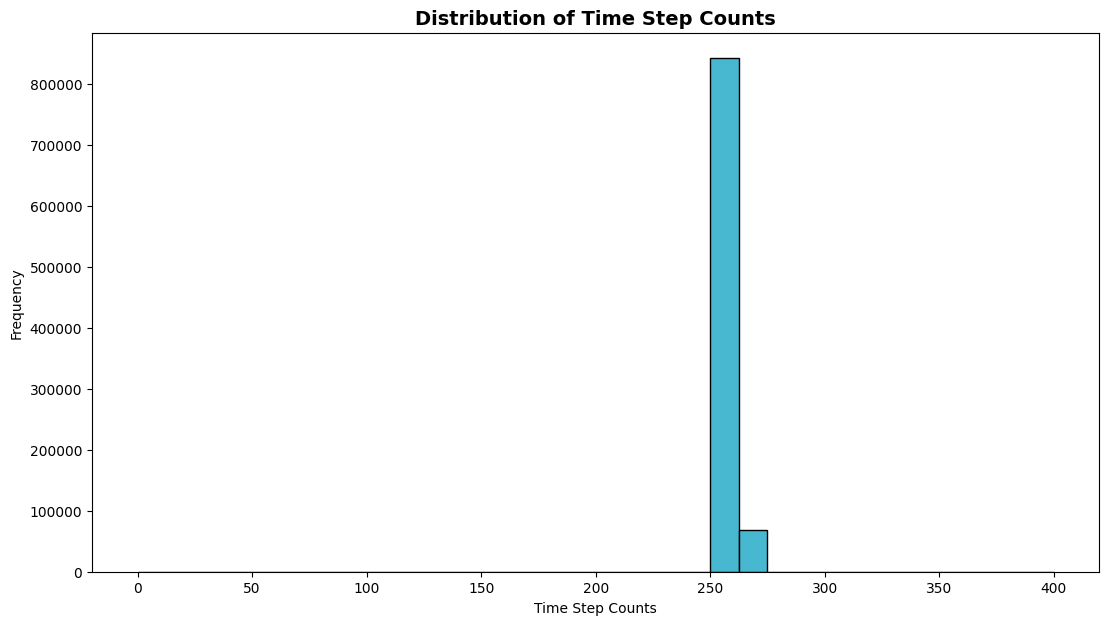

In [11]:
data_statistics_manager.display_time_step_histogram('Distribution of Time Step Counts')

From this we can see that most of the time step data is between 250 and 275. Also, the data has a substantial number of NaN values. This is to be expected, as we saw the wide range of time steps per event. All rows in the data must be padded in some way (NaN here). I will address this later with the data cleanup.

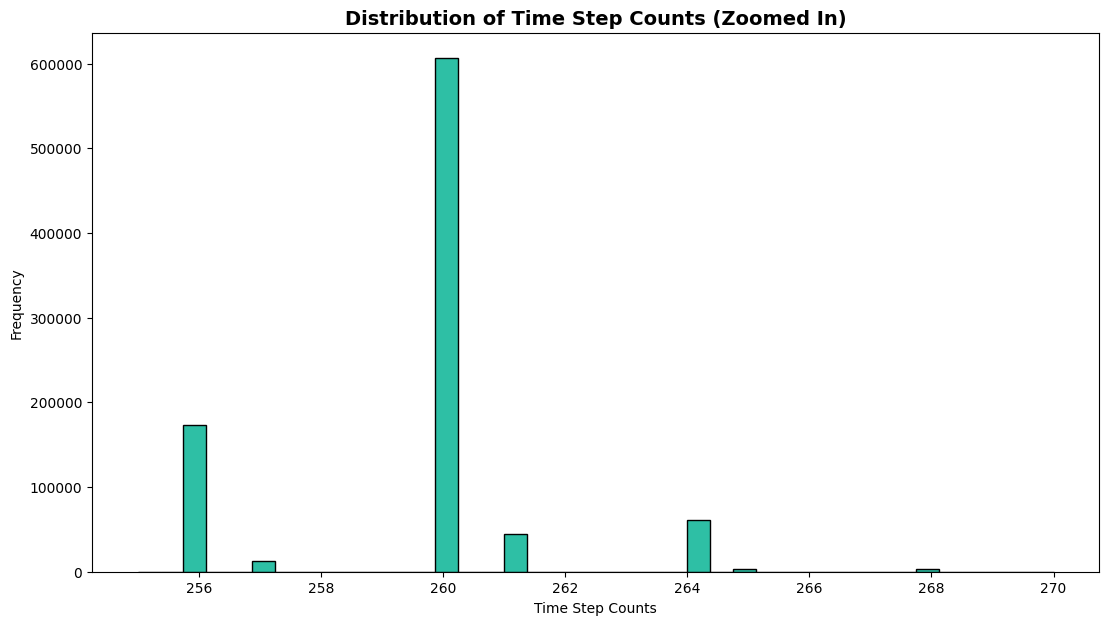

In [12]:
data_statistics_manager.display_time_step_histogram('Distribution of Time Step Counts (Zoomed In)', 40, 255, 270, GREEN_COLOR)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Most common number of time steps:</span>

In [13]:
most_common_timestep = all_data_df['time_steps'].mode().iloc[0]
custom_display("Most common number of time steps:", most_common_timestep)

Because this data is noisy with likely very subtle latent meaning, I want to limit the amount of data that needs to be imputed. I will keep all data with a time step value of 264 or lower. Any NaN value will later be adjusted a more meaningful value.

In [14]:
class DataManager:
    '''
    Used to clean up the dataframe
    '''
    @staticmethod
    def remove_rows(df, column_name, matching_values):
        """
        Only keep specified rows.
        """
        return df[~df[column_name].isin(matching_values)]

    @staticmethod
    def remove_missing_data(df, value_to_keep, remove_events=False):
        """
        Remove columns above a certain number.
        """
        columns_to_drop = [column for column in df.columns if column.startswith('eeg_') and int(column.split('_')[1]) > (value_to_keep-1)]
        df = df.drop(columns=columns_to_drop)

        if remove_events:
            event_ids_to_keep = df[df['time_steps'] == value_to_keep]['event_id'].unique()
            df = df[df['event_id'].isin(event_ids_to_keep)].copy()

        return df

In [15]:
all_data_df = DataManager.remove_missing_data(all_data_df, 264)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">The dataset after removing EEG data above 264 threshold:</span>

In [16]:
DataFrameDisplayManager.display(all_data_df.head(num_channels), "All Data Head:", BLUE_COLOR)

event_id,channel,label,time_steps,eeg_0,eeg_1,eeg_2,eeg_3,eeg_4,eeg_5,eeg_6,eeg_7,eeg_8,eeg_9,eeg_10,eeg_11,eeg_12,eeg_13,eeg_14,eeg_15,eeg_16,eeg_17,eeg_18,eeg_19,eeg_20,eeg_21,eeg_22,eeg_23,eeg_24,eeg_25,eeg_26,eeg_27,eeg_28,eeg_29,eeg_30,eeg_31,eeg_32,eeg_33,eeg_34,eeg_35,eeg_36,eeg_37,eeg_38,eeg_39,eeg_40,eeg_41,eeg_42,eeg_43,eeg_44,eeg_45,eeg_46,eeg_47,eeg_48,eeg_49,eeg_50,eeg_51,eeg_52,eeg_53,eeg_54,eeg_55,eeg_56,eeg_57,eeg_58,eeg_59,eeg_60,eeg_61,eeg_62,eeg_63,eeg_64,eeg_65,eeg_66,eeg_67,eeg_68,eeg_69,eeg_70,eeg_71,eeg_72,eeg_73,eeg_74,eeg_75,eeg_76,eeg_77,eeg_78,eeg_79,eeg_80,eeg_81,eeg_82,eeg_83,eeg_84,eeg_85,eeg_86,eeg_87,eeg_88,eeg_89,eeg_90,eeg_91,eeg_92,eeg_93,eeg_94,eeg_95,eeg_96,eeg_97,eeg_98,eeg_99,eeg_100,eeg_101,eeg_102,eeg_103,eeg_104,eeg_105,eeg_106,eeg_107,eeg_108,eeg_109,eeg_110,eeg_111,eeg_112,eeg_113,eeg_114,eeg_115,eeg_116,eeg_117,eeg_118,eeg_119,eeg_120,eeg_121,eeg_122,eeg_123,eeg_124,eeg_125,eeg_126,eeg_127,eeg_128,eeg_129,eeg_130,eeg_131,eeg_132,eeg_133,eeg_134,eeg_135,eeg_136,eeg_137,eeg_138,eeg_139,eeg_140,eeg_141,eeg_142,eeg_143,eeg_144,eeg_145,eeg_146,eeg_147,eeg_148,eeg_149,eeg_150,eeg_151,eeg_152,eeg_153,eeg_154,eeg_155,eeg_156,eeg_157,eeg_158,eeg_159,eeg_160,eeg_161,eeg_162,eeg_163,eeg_164,eeg_165,eeg_166,eeg_167,eeg_168,eeg_169,eeg_170,eeg_171,eeg_172,eeg_173,eeg_174,eeg_175,eeg_176,eeg_177,eeg_178,eeg_179,eeg_180,eeg_181,eeg_182,eeg_183,eeg_184,eeg_185,eeg_186,eeg_187,eeg_188,eeg_189,eeg_190,eeg_191,eeg_192,eeg_193,eeg_194,eeg_195,eeg_196,eeg_197,eeg_198,eeg_199,eeg_200,eeg_201,eeg_202,eeg_203,eeg_204,eeg_205,eeg_206,eeg_207,eeg_208,eeg_209,eeg_210,eeg_211,eeg_212,eeg_213,eeg_214,eeg_215,eeg_216,eeg_217,eeg_218,eeg_219,eeg_220,eeg_221,eeg_222,eeg_223,eeg_224,eeg_225,eeg_226,eeg_227,eeg_228,eeg_229,eeg_230,eeg_231,eeg_232,eeg_233,eeg_234,eeg_235,eeg_236,eeg_237,eeg_238,eeg_239,eeg_240,eeg_241,eeg_242,eeg_243,eeg_244,eeg_245,eeg_246,eeg_247,eeg_248,eeg_249,eeg_250,eeg_251,eeg_252,eeg_253,eeg_254,eeg_255,eeg_256,eeg_257,eeg_258,eeg_259,eeg_260,eeg_261,eeg_262,eeg_263
67635,AF3,6,260,4395.38,4382.56,4377.44,4387.18,4395.90,4398.46,4396.92,4391.79,4391.28,4395.90,4398.97,4396.41,4392.82,4392.82,4395.38,4398.97,4394.36,4381.54,4376.41,4383.59,4387.18,4388.72,4397.95,4401.54,4397.95,4398.97,4398.97,4395.90,4396.92,4398.46,4397.95,4396.41,4391.79,4389.74,4389.74,4385.64,4387.69,4393.85,4389.74,4381.03,4377.95,4378.46,4377.44,4385.13,4393.33,4389.23,4382.56,4378.97,4375.38,4378.46,4386.15,4389.23,4393.85,4390.26,4374.87,4367.69,4374.87,4384.62,4390.77,4394.36,4390.77,4382.05,4381.03,4385.64,4376.92,4365.64,4373.33,4377.95,4365.13,4363.59,4375.90,4374.36,4368.21,4373.33,4378.46,4375.90,4374.36,4376.41,4377.44,4376.41,4370.26,4370.77,4380.00,4381.54,4378.97,4388.72,4390.77,4376.41,4372.82,4378.46,4376.92,4377.44,4378.46,4375.38,4385.64,4396.92,4387.69,4385.64,4395.90,4390.77,4379.49,4381.03,4379.49,4380.00,4386.67,4388.72,4386.67,4384.62,4383.59,4383.08,4386.67,4388.21,4381.54,4373.33,4375.38,4388.72,4392.82,4386.15,4385.13,4388.21,4382.05,4382.05,4393.85,4395.90,4385.64,4378.97,4373.33,4370.77,4376.92,4382.56,4384.62,4386.67,4384.10,4380.51,4375.90,4371.28,4376.41,4380.00,4369.23,4362.05,4368.72,4373.33,4369.23,4370.26,4373.85,4377.95,4380.00,4373.33,4367.18,4369.74,4373.33,4376.41,4379.49,4373.85,4364.10,4368.72,4374.36,4368.21,4363.08,4368.21,4375.90,4378.97,4381.54,4381.03,4376.92,4374.36,4372.31,4373.33,4376.41,4376.92,4378.46,4387.18,4392.31,4392.82,4391.28,4388.21,4383.59,4378.97,4380.51,4381.03,4372.82,4370.26,4375.90,4380.00,4382.05,4382.05,4381.03,4386.15,4385.64,4375.90,4370.77,4370.26,4373.85,4380.51,4375.90,4371.79,4380.00,4380.51,4370.77,4371.79,4382.05,4387.18,4387.18,4381.54,4373.33,4375.38,4383.59,4384.62,4381.54,4380.51,4378.46,4377.95,4382.56,4382.56,4374.87,4373.33,4378.97,4384.10,4385.13,4384.10,4386.67,4391.79,4393.33,4386.15,4384.62,4393.85,4398.46,4392.82,4388.72,4392.82,4393.33,4389.74,4387.69,4383.08,4380.51,4382.05,4384.10,4386.67,4392.82,4393.33,4388.72,4384.62,4381.54,4383

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Ensuring all events have the same number of channels:</span>

In [17]:
class ChannelCountManager:
    """
    Responsible for getting the unique number of channels for each event.
    """
    def __init__(self, df, expected_num_channels):
        self.df = df
        self.expected_num_channels = expected_num_channels

    def get_incomplete_events(self):
        """
        Return a count of events that don't have the expected number of channels.
        """
        channel_counts = self.df.groupby('event_id')['channel'].nunique()
        return channel_counts[channel_counts != self.expected_num_channels]

In [18]:
channel_count_manager = ChannelCountManager(all_data_df, num_channels)
incomplete_events = channel_count_manager.get_incomplete_events()

custom_display(f'Number of events_ids with unexpected channel count ({num_channels})', len(incomplete_events))

This shows that all event_ids have the expected number of channels.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Class Distribution:</span>

In [19]:
class CountDistributionDisplay:
    """
    Used to display a distribution of counts
    """
    @staticmethod
    def display(title, counts, labels, colors, x_axis_label, text_color='black'):
        """
        Displays a pie chart and bar chart side-by-side for class data
        """
        def add_pie_chart():
            ax[0].pie(counts, labels=labels, autopct='%1.1f%%', textprops={'fontsize': DISPLAY_FONT_SIZE * 0.95, 'fontweight':'bold', 'color': text_color},
                startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
    
        def add_bar_chart():
            bars = ax[1].bar(labels, counts, width=0.5, color=colors, edgecolor='black')
            ax[1].set_xticks(range(len(labels)))
            ax[1].set_xlabel(x_axis_label, fontsize=DISPLAY_FONT_SIZE)
            ax[1].set_ylabel('Count', fontsize=DISPLAY_FONT_SIZE)
            ax[1].grid(axis='y', linestyle='solid', alpha=0.4)
    
            for bar in bars:
                ax[1].text(
                    bar.get_x() + bar.get_width() / 2.0, bar.get_height() / 3.0, f'{bar.get_height()}', ha='center',
                    fontsize=12, fontweight='bold', color=text_color)
        
        figure, ax = plt.subplots(1, 2, figsize=(13, 7), gridspec_kw={'width_ratios': [1, 1]})
        figure.suptitle(title, fontsize=TITLE_FONT_SIZE, fontweight='bold', color='royalblue')
    
        add_pie_chart()
        add_bar_chart()
        
        plt.tight_layout()
        plt.show()

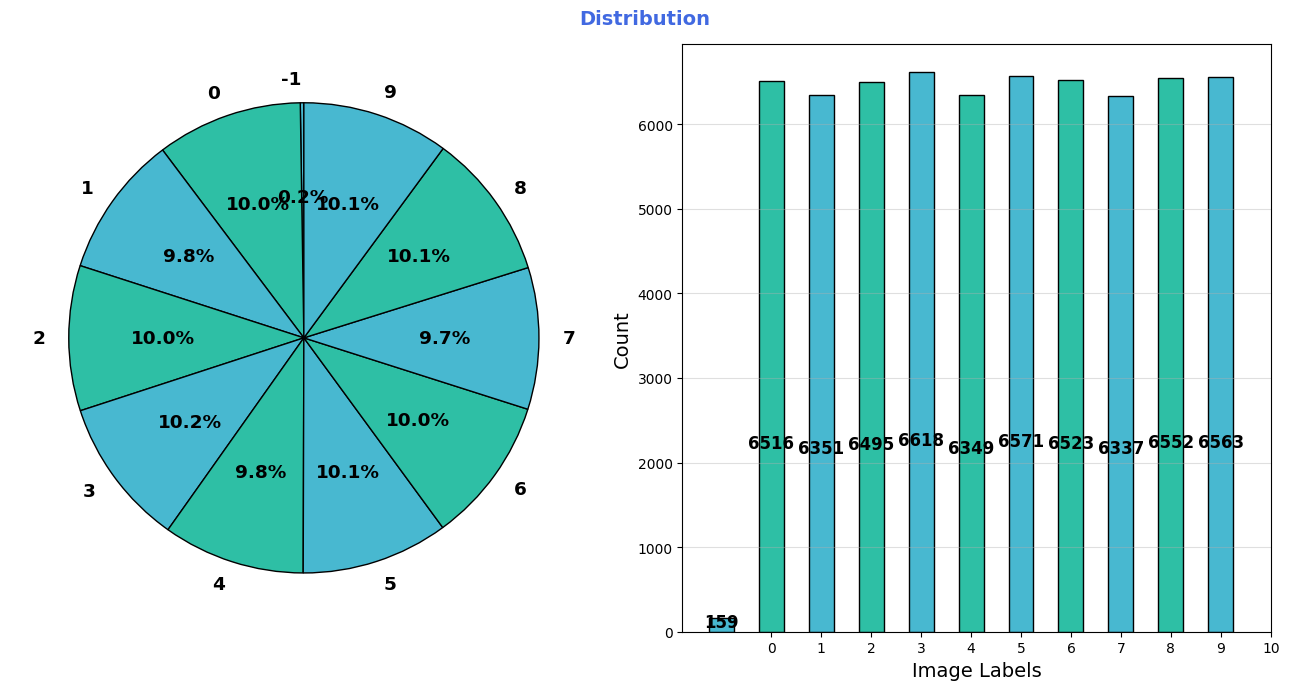

In [20]:
label_counts = all_data_df['label'].value_counts().sort_index() // num_channels

COLOR1 = '#48B8D0'
COLOR2 = '#2EBFA5'
CountDistributionDisplay.display('Distribution', 
                                 label_counts, 
                                 label_counts.index.tolist(), 
                                 [COLOR1, COLOR2]*int(len(label_counts)/2), 
                                 'Image Labels')

In [21]:
DataFrameDisplayManager.display(label_counts.reset_index(), "Class Counts", GREEN_COLOR)

label,count
-1,159
0,6516
1,6351
2,6495
3,6618
4,6349
5,6571
6,6523
7,6337
8,6552


Other than the label of **-1**, the data looks to be well-balanced, with all class labels around 10%. From the data source:  **"-1 for random captured signals not related to any of the digits."** For this project I won't be using this, so I'll remove any data that relates to this label.

In [22]:
# Removing events with label -1
all_data_df = DataManager.remove_rows(all_data_df, 'label', [-1])

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Checking for Duplicates:</span>

In [23]:
class DuplicateCheck:
    """
    Checks for duplicate data.
    """
    @staticmethod
    def get_duplicate_count(df):
        all_eeg = [col for col in df.columns if col.startswith('eeg')]
        duplicate_mask = df.duplicated(subset=all_eeg)
        duplicate_rows = df[duplicate_mask]
        
        return duplicate_rows, duplicate_mask.sum()


In [24]:
duplicate_rows, duplicate_count = DuplicateCheck.get_duplicate_count(all_data_df)
custom_display("Duplicate EEG data count", duplicate_count)

These duplicates will be across event_ids. The number is so low compared to the total events, so I will remove them.

In [25]:
all_data_df = DataManager.remove_rows(all_data_df, 'event_id', duplicate_rows['event_id'].unique().tolist())

In [26]:
#Verifying duplicates removed
_, duplicate_count = DuplicateCheck.get_duplicate_count(all_data_df)
custom_display("Duplicate EEG data count", duplicate_count)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Missing data check:</span>

In [27]:
missing_count = all_data_df.isnull().sum()
DataFrameDisplayManager.display(missing_count.reset_index(), "Missing Data", BLUE_COLOR)

index,0
event_id,0
channel,0
label,0
time_steps,0
eeg_0,0
eeg_1,0
eeg_2,0
eeg_3,0
eeg_4,0
eeg_5,0


In [28]:
custom_display("Total missing", missing_count.sum())

From this we can see there is a large number of entries with NaN. This is expected as the number of time steps varies from one event to another. As mentioned above, we will fix this later.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Looking at the data again:</span>

This shows that the event_ids with a label of **-1** has been removed.

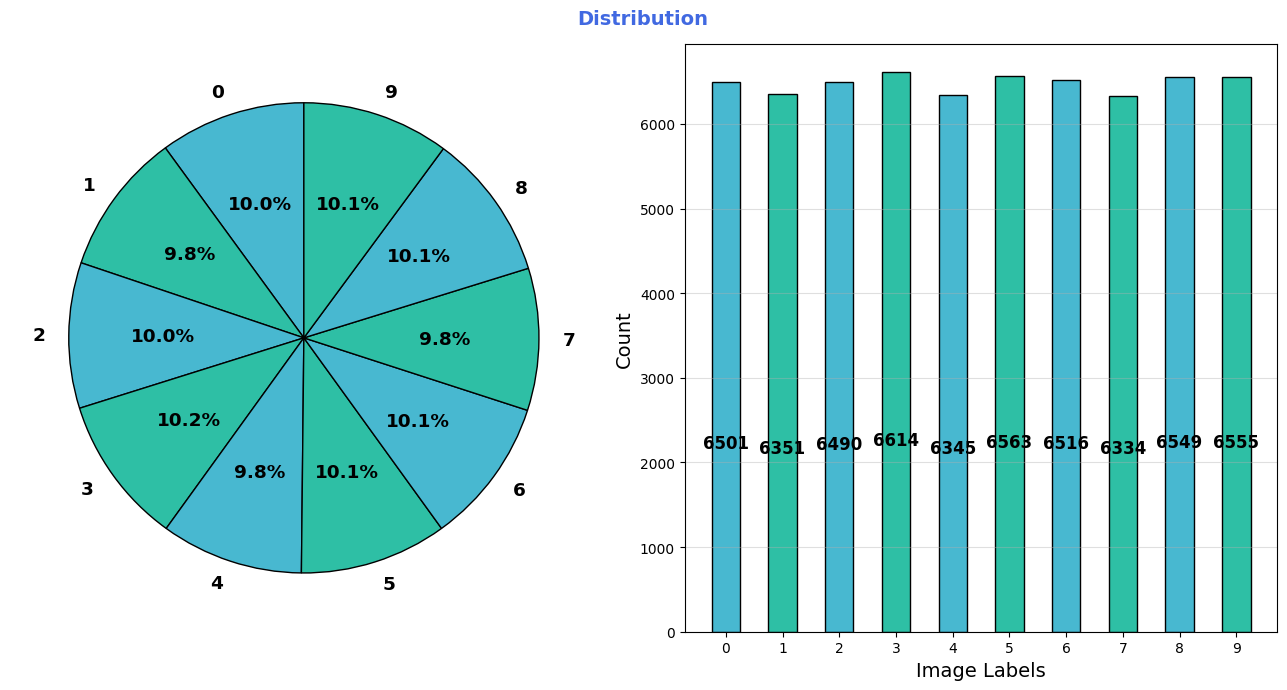

In [29]:
label_counts = all_data_df['label'].value_counts().sort_index() // num_channels
CountDistributionDisplay.display('Distribution', 
                                 label_counts, 
                                 label_counts.index.tolist(), 
                                 [COLOR1, COLOR2]*int(len(label_counts)/2), 
                                 'Image Labels')

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Converting data into form useable for model training:</span>

In [30]:
class DataConverter:
    """
    Convert the DataFrame into a Numpy matrices.
    """
    @staticmethod
    def convert(df):
        grouping = df.groupby('event_id')
        x = []
        y = []
        for event_id, group in grouping:
            group_sorted = group.sort_values('channel')
            x.append(group_sorted.iloc[:, 3:].to_numpy(dtype=float))
            y.append(group_sorted['label'].iloc[0])
        
        return (np.stack(x), np.array(y))       

In [31]:
X, y = DataConverter.convert(all_data_df)
X = X[:, :, 1:] 

In [32]:
print(X.shape, y.shape)

(64818, 14, 264) (64818,)


From this we get X: (event count, channel count, time_step count) and y: expected class value. We will see later that this needs to be adjusted a bit for use with CNN and RNN models, but it's an easy adjustment.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Train/Validation/Test Split:</span>

Before we start evaluating models, the data needs to be split. I'm going to use 80% of the data for training and 20% for validation and testing.

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=SEED_VALUE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED_VALUE, stratify=y_temp)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Standardize:</span>

Before the data can be used in training, it needs to be standardized so a neural network can use it properly.

This will center the data around zero and scale it to have unit variance.

In [34]:
class StandardizationManager:
    """
    This will standardize the data by centering around 0 and scaling it to have a standard deviation of 1 (unit variance).
    """
    @staticmethod
    def standardize(X_input, X_val_input, X_test_input):
        """
        Standardizes the training, validation,and test data. The validation and test data is standardized using
        the statistics from the training data.

        Any missing values are replaced with 0.
        """
        mean = np.nanmean(X_input, axis=(0, 2), keepdims=True)
        std = np.nanstd(X_input, axis=(0, 2), keepdims=True)
        std = np.where(std==0, 1e-8, std)
        
        X_std = (X_input-mean)/std
        X_std = np.nan_to_num(X_std, nan=0.0)

        X_val_std = (X_val_input-mean)/std
        X_val_std = np.nan_to_num(X_val_std, nan=0.0)

        X_test_std = (X_test_input-mean)/std
        X_test_std = np.nan_to_num(X_test_std, nan=0.0)
        
        return X_std, X_val_std, X_test_std

In [35]:
# The data will be standardized before it is used in the models.
X_train_std, X_val_std, X_test_std = StandardizationManager.standardize(X_train, X_val, X_test)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Visualizing Standardization:</span>

Below is an example of the result of standardization. On the left is the data before standardization is applied, and on the right, after standardization has been applied.

As you can see, the data is centered around zero and includes positive and negative values. I will take advantage of that later using a Leaky ReLU activation function.

In [36]:
class StandardizationPlotManager:
    """
    Displays a sample of the data before and after standardization.
    """
    @staticmethod
    def plot_values():
        plt.figure(figsize=(12, 5))
        
        for i in range(num_channels):
            plt.subplot(1, 2, 1)
            plt.plot(X_train[1, i], label=f'Channel {i+1}')
            plt.title("Before Standardization")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(X_train_std[1, i], label=f'Channel {i+1}')
            plt.title("After Standardization")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()

        plt.tight_layout()
        plt.show()   

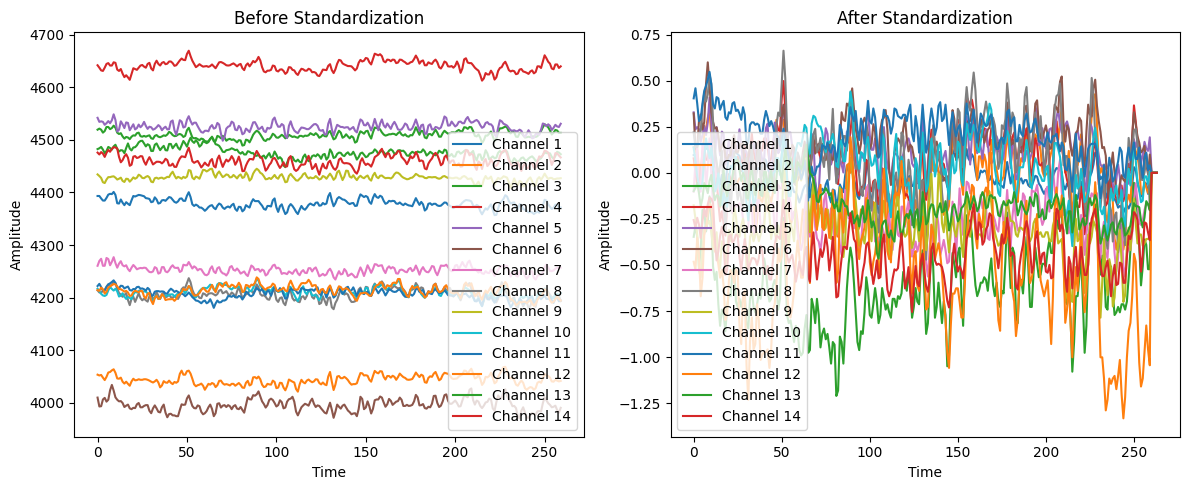

In [37]:
StandardizationPlotManager.plot_values()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">EDA and Data Cleaning Summary and Discussion</span>
* I started out with loading the data into a Pandas DataFrame. I included the event_id, channel, label, time_steps, and actual sensor data.
* The number of rows in the data frame started out as 910,476 with a substantial amount of missing data. This was because not all the events had the same number of time steps.
* Using a histogram, it was shown that most of the time steps where in the 250-275 count range. From this, a maximum number of timesteps was chosen and values above that were discarded.
* It was then verified that all the events had the same number of channels. This is important, as later the models will expect this.
* A class distribution was performed where we discovered that there was a **-1** class. After reviewing the source site of the data, any event with this label was removed as it won't be used.
* Next the data was checked for duplicates. It was found there were a relatively few number of duplicates, so they were removed.
* The data was checked for missing data. It was discovered that there was a large amount in the EEG data, but the other fields were OK. This missing data in the EEG fields was addressed with the standardization process.
* The data was converted into a format more usable for model training. It was separated into X and y data in the form X: (event count, channel count, time_step count) and y: (expected label count,)
* The data was the split up into training, validation, and test data typically used in machine learning.
* The data was standardized to be centered around zero having unit variance. The validation and test data used the statistics from the training data to perform the standardization.
* Finally, an example of what the data looks like before and after standardization.

From this EDA and cleanup steps, I am ready to use this to design the models.

## <span style="color: royalblue;">Model Architecture</span>

From the EDA section we saw that the data is spread over a number of channels and has a time element to it. That is, from the data source site, the readings are made at a rate of 128 Hz, which means 128 samples per second. This gives us the roughly 256 EEG readings across the channels. When we learned about convolutional neural networks **(CNN)**, we saw that color images typically have 3 channels (along with a height and width). Here we have 14 channels, but only a "width" for the data. From the article **Convolutional Neural Networks for EEG Brain-Computer Interfaces**, it states "Images and audio signals often have a hierarchical structure, where nearby features are important for the current features, and far away features less so. When EEG data is seen as a 2D-array, with the number of time steps as the width, and the number of electrodes as the height, EEG data has similar characteristics to an image or audio signal." This can be summarized as: If the data is moved around (e.g. moving around columns) and it loses it's information, then it has a spatial relationship. Keras has a Conv1D layer that will work for this. Using this we can apply the same concepts learned with using CNNs with images. That is, using kernels and pooling layers to learn the patterns.

Also, since the readings are time-dependent, using a recurrent neural network **(RNN)** might be useful in uncovering temporal relationships.

In this project I plan on trying out both architectures (individually and in combination).

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Model analysis support code:</span>

In [38]:
class ClassificationAndConfusionMatrixManager:
    """
    Manages the display of the classification report and confusion matrix
    """
    def __init__(self, fit_model, y_test):
        self.model = fit_model
        self.y_test = y_test
        self.classification_report_df = None
        
    def display(self):
        figure, ax = plt.subplots(figsize=(11, 5))
        ax.axis('off')
        
        figure.suptitle("Classification Report and Confusion Matrix", fontsize=TITLE_FONT_SIZE, fontweight='bold')

        gs = gridspec.GridSpec(1,3, width_ratios=[1, 0, 1])
        ax0 = figure.add_subplot(gs[0])
        ax1 = figure.add_subplot(gs[2])

        ax0.axis('tight')
        ax0.axis('off')

        y_pred_probabilities = self.model.predict(np.transpose(X_test_std,(0,2,1)))
        y_pred = np.argmax(y_pred_probabilities, axis=1)
        
        # Using SKLearn metric library
        classification_report_df = pd.DataFrame(classification_report(self.y_test, y_pred, output_dict=True, digits=4, zero_division=0)).transpose()
        self.classification_report_df = classification_report_df

        # Creating a table to display the classification report data frame
        table = ax0.table(cellText=classification_report_df.round(4).values,
                            colLabels=classification_report_df.columns,
                            rowLabels=classification_report_df.index,
                            cellLoc='center',
                            loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.1, 1.1)

        cm = confusion_matrix(self.y_test, y_pred)
        confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        confusion_matrix_display.plot(ax=ax1, cmap='Purples', values_format='d')
        ax1.set_title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

        return classification_report_df.loc['accuracy','f1-score']

In [39]:
class AccuracyResults:
    """
    Handles the display of the resulting accuracy and AUC plots.
    """

    def __init__(self, model, title):
        self.model = model
        self.title=title

    def display_accuracy_plots(self):
        def add_plot(current_ax, val1_key, val2_key, label1, label2, y_label, title):
            val1 = self.model.results.history[val1_key]
            epoch_list = list(range(1, len(val1) + 1))
            current_ax.plot(epoch_list, val1, linestyle='dashed', color='magenta', label=label1)
            current_ax.plot(epoch_list, self.model.results.history[val2_key], linestyle='solid', color='blue', label=label2)
            if len(epoch_list) <= 18:
                current_ax.set_xticks(epoch_list)
            current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            current_ax.set_xlabel('Epoch')
            current_ax.set_ylabel(y_label)
            current_ax.set_title(title)
            current_ax.legend()

        figure, ax = plt.subplots(figsize=(13, 4))
        figure.suptitle(self.title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax.axis('off')
        
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0, 1])

        add_plot(figure.add_subplot(gs[0]), 
                 'accuracy', 
                 'val_accuracy', 
                 'Train Accuracy', 
                 'Validation Accuracy', 
                 'Accuracy', 
                 'Train and Validation Accuracy')

        add_plot(figure.add_subplot(gs[2]), 
                 'loss', 
                 'val_loss', 
                 'Train Loss', 
                 'Validation Loss', 
                 'Loss', 
                 'Train and Validation Loss')

        plt.tight_layout()
        plt.show()

    def display_auc_plot(self):
        auc = self.model.results.history['auc']
        epoch_list = list(range(1, len(auc) + 1))
        plt.figure(figsize=(11,5))
        plt.plot(epoch_list, auc, linestyle='dashed', color='magenta', label='Train AUC')
        plt.plot(epoch_list, self.model.results.history['val_auc'], linestyle='solid', color='blue', label='Validation AUC')
        if len(epoch_list) <= 19:
            plt.xticks(epoch_list)
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.title('Train and Validation AUC')
        plt.legend()
        plt.show()

In [40]:
class AucCallback(Callback):
    """
    Custom callback to calculate and store AUC data for both the training and validation data. This will be useful
    when training the the models.
    """
    def __init__(self, X_training, y_training, X_validation, y_validation):
        self.X_training = tf.convert_to_tensor(X_training, dtype=tf.float32)
        self.y_training = np.array(tf.keras.utils.to_categorical(y_training, num_classes=10))
        self.X_validation = tf.convert_to_tensor(X_validation, dtype=tf.float32)
        self.y_validation = np.array(tf.keras.utils.to_categorical(y_validation, num_classes=10))

    def __calculate_auc(self, X, y, key, logs):
        """
        Private method to calcuate the AUC score.
        """
        y_predicted = self.model.predict(X, verbose=0)
        if isinstance(y_predicted, tf.Tensor):
            y_predicted = y_predicted.numpy()
            
        auc = roc_auc_score(y, y_predicted, multi_class='ovr', average='macro')
        logs[key] = auc
        
    def on_epoch_end(self, epoch, logs=None):
        """
        This method will be called at the end of each epoch. Values are stored in the logs.
        """
        logs = logs or {}
        self.__calculate_auc(self.X_training, self.y_training, 'auc', logs)
        self.__calculate_auc(self.X_validation, self.y_validation, 'val_auc', logs)

In [41]:
class TestAccuracyAndAucPlotManager:
    """
    Responsible for storing and displaying the test data accuracy and AUC scores.
    """
    def __init__(self, X_testing, y_testing):
        self.accuracy_records = []
        self.auc_records = []
        self.X_testing = tf.convert_to_tensor(np.transpose(X_testing,(0,2,1)), dtype=tf.float32)
        self.y_testing = np.array(tf.keras.utils.to_categorical(y_testing, num_classes=10))

    def add_record(self, model_name, accuracy_value, model):
        """
        Store the test accuracy and then calculate and store the AUC value for a given model.
        """
        self.accuracy_records.append((accuracy_value, model_name))

        y_predicted = model.predict(self.X_testing, verbose=0)
        
        if isinstance(y_predicted, tf.Tensor):
            y_predicted = y_predicted.numpy()
        
        auc = roc_auc_score(self.y_testing, y_predicted, multi_class='ovr', average='macro')

        self.auc_records.append((auc, model_name))


    def __handle_plot(self, x_axis_names, values, y_label, title, line_label, color):
        """
        Private method to handle the displaying of the accuracy or AUC plot.
        """
        plt.figure(figsize=(11,5))
        plt.plot(x_axis_names, values, linestyle='solid', color=color, label=line_label)
        
        plt.xlabel('Models')
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.show()
        
    def display_accuracy_plot(self):
        """
        Display an accuracy plot for the stored model data.
        """
        model_names = [container[1] for container in self.accuracy_records]
        values = [container[0] for container in self.accuracy_records]

        self.__handle_plot(model_names, values, "Accuracy", "Test Accuracy Across Models", "Test Accuracy", 'blue')

    def display_auc_plot(self):
        """
        Display an AUC plot for the stored model data.
        """
        model_names = [container[1] for container in self.auc_records]
        values = [container[0] for container in self.auc_records]

        self.__handle_plot(model_names, values, "AUC", "Test AUC Across Models", "Test AUC", 'magenta')

    def display_legend(self):
        """
        Display a table explaining the model name shorthand.
        """
        legend_dictionary = {'basic_cnn': 'Basic CNN',
                             'basic_cnn_reg': 'Basic CNN with Regularization',
                             'basic_cnn_reg_lr': 'Basic CNN with Regularization and Leaky ReLU',
                             'gru': 'GRU RNN',
                             'bidirectional_gru': 'Bidirectional GRU',
                             'large_cnn': 'Large CNN',
                             'large_hybrid': 'Large CNN-GRU Hybrid',
                            }

        legend_df = pd.DataFrame(list(legend_dictionary.items()), columns=['Model', 'Description'])

        figure, ax = plt.subplots(figsize=(12, 5))
        ax.axis('off')

        table = ax.table(cellText=legend_df.values, colLabels=legend_df.columns, cellLoc="left", loc="center")
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width([0,1])
        [row.set_height(0.07) for row in table.get_celld().values()]

        plt.tight_layout()
        plt.show()
        

In [87]:
test_accuracy_and_auc_plot_manager = TestAccuracyAndAucPlotManager(X_test_std, y_test)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Abstract base model class to handle common tasks:</span>

Notable with this base class is that all models will be fit using **EarlyStopping** and a **ReduceLROnPlateau** learning rate scheduler. Upon early stopping, the best weights will be restored to the model. It will also use the custom **AucCallback**.

In [43]:
class AbstractBaseModel(ABC):
    """
    Handles the common classes for the model training (fitting)
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        self.X_training = X_training
        self.y_training = y_training
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        self.model = None
        self.results = None
        
    @abstractmethod
    def build_model(self):
        # Override in subclass
        pass

    def fit_model(self):
        """
        Sets the callback, class weight, and trains the model.
        """
        self.model = self.build_model()

        # All models will use early stopping when the validation loss starts to get worse.
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.early_stopping_patience, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
        auc_callback = AucCallback(self.X_training, self.y_training, self.X_validation, self.y_validation)
        
        # Fit the model and return the history
        self.results = self.model.fit(self.X_training, 
                          self.y_training, 
                          validation_data=(self.X_validation, self.y_validation), 
                          epochs=self.max_epochs, batch_size=self.batch_size, callbacks=[early_stopping, lr_scheduler, auc_callback])

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Basic CNN:</span>

I will start with a basic CNN model to serve as a baseline of sorts. This model is just meant to get a feel for how the data works with a CNN.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

This will be relatively basic and small with only one convolutional layer and two dense layers (one being the output layer). Standard **ReLU** activation functions will be used throughout. For the convolutional layer, I will use max pooling and batch normalization. 

After the convolutional layer is flattened, I will use a small dense layer.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

For the convolutional layer, I used 20 filters with a standard kernel size of 2. The MaxPooling1D layer uses the default kernel size of 2.

For the dense layer, I used 16 nodes. This feeds into the output layer that uses a **softmax** activation since it has 10 possible classes.

With the Adam optimizer, I'm using a learning rate of 0.001. This, of course, can change because of the **ReduceLROnPlateau** callback all models will use.

In [44]:
class BasicCNNModel(AbstractBaseModel):
    """
    A Small CNN model
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(Conv1D(20, kernel_size=2, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), input_shape=self.X_training.shape[1:]))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(MaxPooling1D())
        
        model.add(Flatten())
        
        model.add(Dense(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+2)))
        model.add(BatchNormalization())
        model.add(ReLU())
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [45]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
basic_cnn_model = BasicCNNModel(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 50, 32, 10)
basic_cnn_model.fit_model()

Epoch 1/50
1621/1621 [==============================] - 22s 12ms/step - loss: 2.3082 - accuracy: 0.1085 - val_loss: 2.2933 - val_accuracy: 0.1194 - lr: 0.0010 - auc: 0.5493 - val_auc: 0.5360
Epoch 2/50
1621/1621 [==============================] - 24s 15ms/step - loss: 2.2857 - accuracy: 0.1319 - val_loss: 2.2807 - val_accuracy: 0.1402 - lr: 0.0010 - auc: 0.5690 - val_auc: 0.5573
Epoch 3/50
1621/1621 [==============================] - 24s 15ms/step - loss: 2.2743 - accuracy: 0.1437 - val_loss: 2.2757 - val_accuracy: 0.1429 - lr: 0.0010 - auc: 0.5828 - val_auc: 0.5652
Epoch 4/50
1621/1621 [==============================] - 24s 15ms/step - loss: 2.2668 - accuracy: 0.1518 - val_loss: 2.2721 - val_accuracy: 0.1413 - lr: 0.0010 - auc: 0.5881 - val_auc: 0.5677
Epoch 5/50
1621/1621 [==============================] - 23s 14ms/step - loss: 2.2604 - accuracy: 0.1543 - val_loss: 2.2672 - val_accuracy: 0.1498 - lr: 0.0010 - auc: 0.5962 - val_auc: 0.5768
Epoch 6/50
1621/1621 [=======================

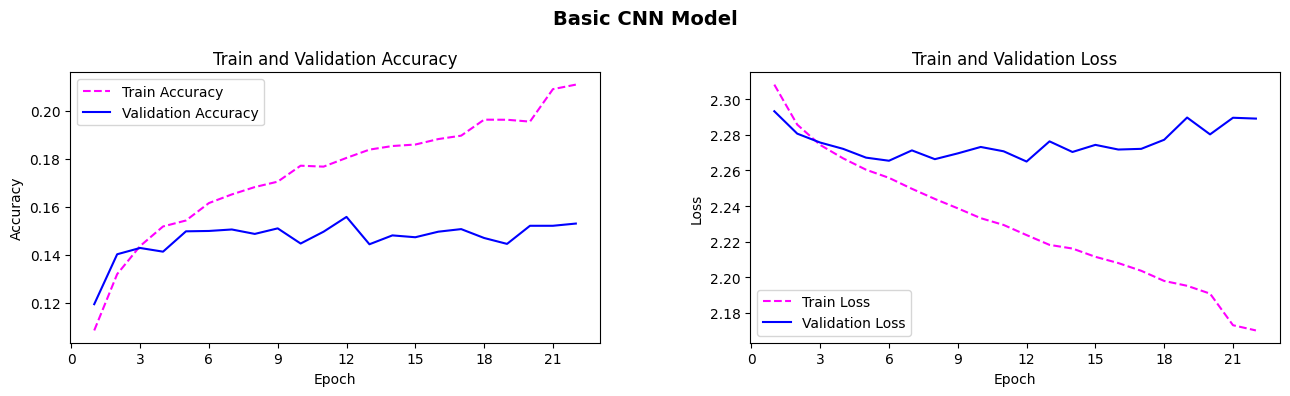

In [46]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(basic_cnn_model, "Basic CNN Model")
accuracy_results.display_accuracy_plots()

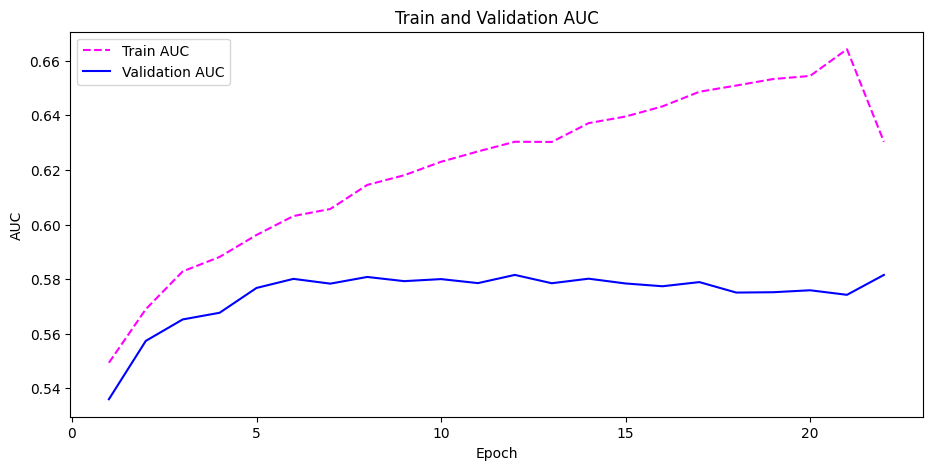

In [47]:
# Display a AUC plot over the epochs for both the training and validation data
accuracy_results.display_auc_plot()

From the accuracy plot, two things are clear. First, the EEG data is very noisy and it's going to be difficult to extract meaningful patterns from it. And second, with the simple model, it is evident that it is overfitting the training data.

From the loss plot on the right, we can see the validation data struggles to keep up with the training loss.

However, this is just the first model to get a baseline. I have no doubt we can improve with a more complex model and some hyperparameter tuning.

203/203 [==============================] - 1s 4ms/step


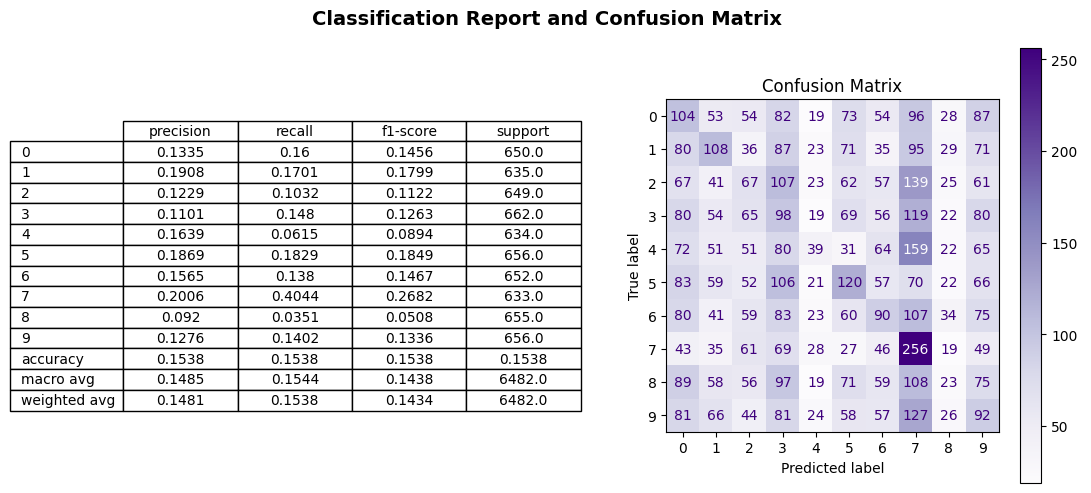

In [88]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(basic_cnn_model.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [89]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("basic_cnn", accuracy_value, basic_cnn_model.model)

The precision and recall are similar to the accuracy measure. While it's quite low, there does seem to be something in the data that the model is picking up. The highest precision and recall was for the digit 7. Perhaps that's the easiest to think about for the subject? It's too early to say but it is interesting to see this. 

Looking at the confusion matrix, it is somewhat random, however the diagonal does stick out somewhat for all digits other than six and eight. Again, it's too early and this model is likely too simple to make a definitive judgement. We can also see that the number 7 was the most accurate here.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Basic CNN with Regularization:</span>

From the analysis of the previous model, we saw that the model was overfitting on the training data. This wasn't surprising as we didn't attempt to use any regularization. That model was just to get a feel for how the model will work with the EEG data. For this model, it will basically be the same except for some L2 regularization. Hopefully this will help with the noisy data. I'm not expecting much of an improvement with this model other than the validation accuracy to follow the training accuracy better. The model is still quite simple and will likely need to be a bit more complex to see better results.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

No fundamental architecture changes from the previous model. I want to get a feel for how regularization affects the learning.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Both the convolutional layer and dense layer will use L2 regularization with a rather aggressive value. This should help the model keep from overfitting on the training data and hopefully generalize better.

In [50]:
class BasicCNNModelWithRegularization(AbstractBaseModel):
    """
    A Small CNN model with L2 regularization.
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(Conv1D(20, kernel_size=2, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), input_shape=self.X_training.shape[1:], kernel_regularizer=regularizers.L2(0.005)))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(MaxPooling1D())
        
        model.add(Flatten())
        
        model.add(Dense(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(0.005)))
        model.add(BatchNormalization())
        model.add(ReLU())
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(0.005), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [51]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
basic_cnn_model_with_regularization = BasicCNNModelWithRegularization(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 100, 32, 10)
basic_cnn_model_with_regularization .fit_model()

Epoch 1/100
1621/1621 [==============================] - 20s 12ms/step - loss: 2.3991 - accuracy: 0.1102 - val_loss: 2.3498 - val_accuracy: 0.1160 - lr: 0.0010 - auc: 0.5253 - val_auc: 0.5194
Epoch 2/100
1621/1621 [==============================] - 24s 15ms/step - loss: 2.3183 - accuracy: 0.1181 - val_loss: 2.3091 - val_accuracy: 0.1277 - lr: 0.0010 - auc: 0.5350 - val_auc: 0.5351
Epoch 3/100
1621/1621 [==============================] - 25s 15ms/step - loss: 2.3072 - accuracy: 0.1260 - val_loss: 2.3107 - val_accuracy: 0.1230 - lr: 0.0010 - auc: 0.5402 - val_auc: 0.5383
Epoch 4/100
1621/1621 [==============================] - 25s 15ms/step - loss: 2.3053 - accuracy: 0.1292 - val_loss: 2.3142 - val_accuracy: 0.1171 - lr: 0.0010 - auc: 0.5374 - val_auc: 0.5373
Epoch 5/100
1621/1621 [==============================] - 25s 15ms/step - loss: 2.3020 - accuracy: 0.1308 - val_loss: 2.3092 - val_accuracy: 0.1169 - lr: 0.0010 - auc: 0.5458 - val_auc: 0.5407
Epoch 6/100
1621/1621 [=================

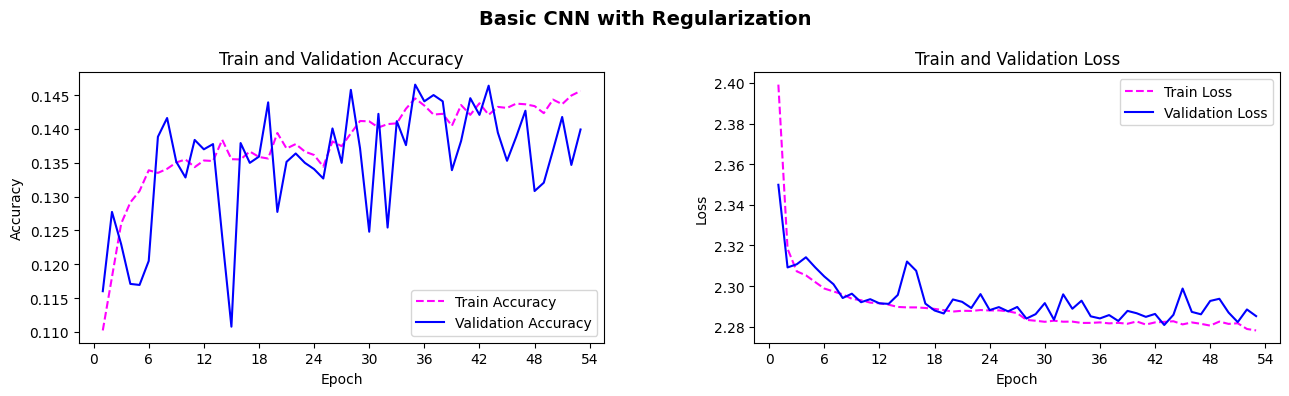

In [52]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(basic_cnn_model_with_regularization, "Basic CNN with Regularization")
accuracy_results.display_accuracy_plots()

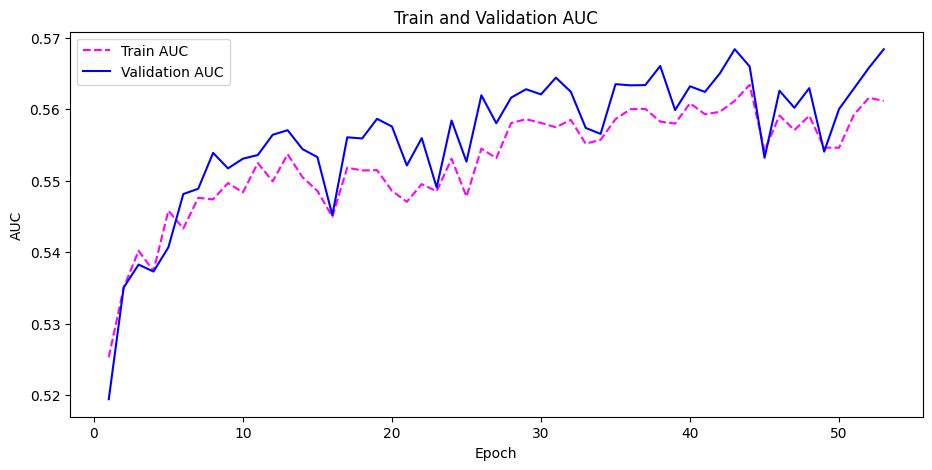

In [53]:
# Display a AUC plot over the epochs for both the training and validation data
accuracy_results.display_auc_plot()

With the added L2 regularization, the validation loss on followed the training loss better. The accuracy plot showed the validation accuracy being quite choppy but following the training curve better.

203/203 [==============================] - 1s 4ms/step


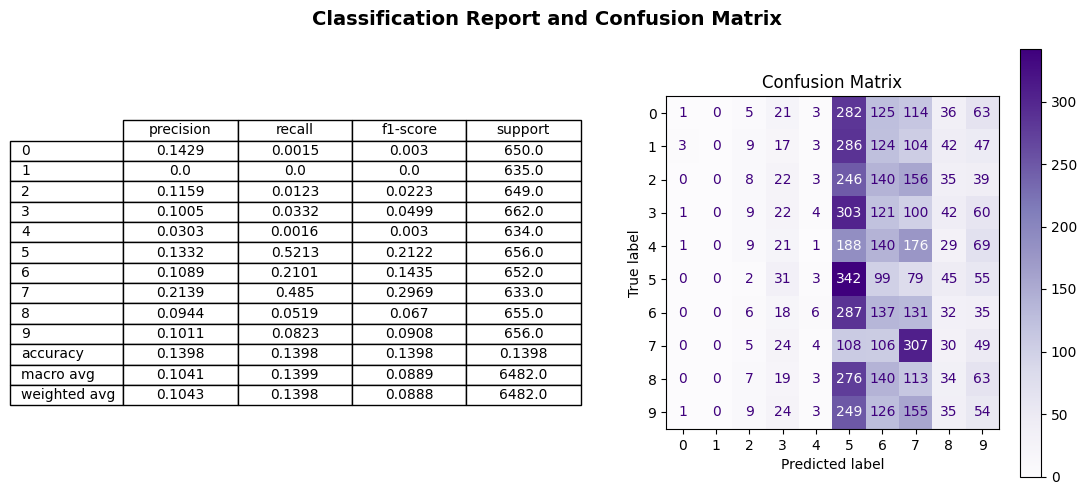

In [90]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(basic_cnn_model_with_regularization.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [91]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("basic_cnn_reg", accuracy_value, basic_cnn_model_with_regularization.model)

While the regularization might have helped the overfitting issue with the training data, the model did not appear to generalize any better. I think the model is just too simple for good results. Again, "7" seemed to perform the best here. The confusion matrix seems to be biased. Perhaps this model needs to train longer because of the regularization. The F1 score is a bit low (other than for 7), so this particular model isn't performing that good. I don't want to spend too much time on these smaller models though.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Basic CNN with Regularization and Leaky ReLU:</span>

With the previous model, the "standard" ReLU activation function was used. With this model, I will switch to a LeakyReLU. Reason being is that with the standardization we saw that the data is centered around zero and includes both positive and negative values. Since a typical ReLU activation function will remove all negative values, it is possible it is removing some important information from the data.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

The only notable change here is switching from a ReLU activation to a Leaky ReLU. This will be changed for both the convolutional layer as well as the dense layer. The output layer will obviously keep its softmax activation.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

For this model, I will back off the L2 regularization a little as I think the previous model might have had too much L2 regularization.

In [56]:
class BasicCNNModelWithRegularizationAndLeakyReLU(AbstractBaseModel):
    """
    A Small CNN model with regularization using a leaky ReLU activation function.
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(Conv1D(20, kernel_size=2, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), input_shape=self.X_training.shape[1:], kernel_regularizer=regularizers.L2(1e-3)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D())
        
        model.add(Flatten())
        
        model.add(Dense(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-3)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(1e-3), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [57]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
basic_cnn_model_with_regularization_lr = BasicCNNModelWithRegularizationAndLeakyReLU(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 100, 32, 10)
basic_cnn_model_with_regularization_lr.fit_model()

Epoch 1/100
1621/1621 [==============================] - 23s 14ms/step - loss: 2.3571 - accuracy: 0.1085 - val_loss: 2.3295 - val_accuracy: 0.1148 - lr: 0.0010 - auc: 0.5397 - val_auc: 0.5284
Epoch 2/100
1621/1621 [==============================] - 26s 16ms/step - loss: 2.3174 - accuracy: 0.1264 - val_loss: 2.3118 - val_accuracy: 0.1276 - lr: 0.0010 - auc: 0.5518 - val_auc: 0.5466
Epoch 3/100
1621/1621 [==============================] - 24s 15ms/step - loss: 2.3058 - accuracy: 0.1367 - val_loss: 2.3088 - val_accuracy: 0.1351 - lr: 0.0010 - auc: 0.5549 - val_auc: 0.5481
Epoch 4/100
1621/1621 [==============================] - 25s 16ms/step - loss: 2.3004 - accuracy: 0.1375 - val_loss: 2.3110 - val_accuracy: 0.1330 - lr: 0.0010 - auc: 0.5468 - val_auc: 0.5443
Epoch 5/100
1621/1621 [==============================] - 24s 15ms/step - loss: 2.2958 - accuracy: 0.1377 - val_loss: 2.2959 - val_accuracy: 0.1362 - lr: 0.0010 - auc: 0.5557 - val_auc: 0.5539
Epoch 6/100
1621/1621 [=================

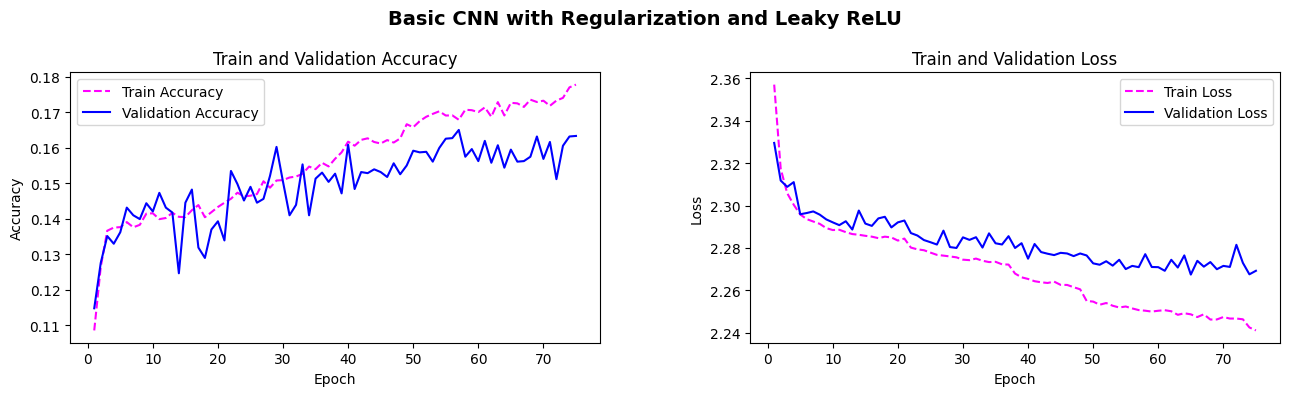

In [58]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(basic_cnn_model_with_regularization_lr, "Basic CNN with Regularization and Leaky ReLU")
accuracy_results.display_accuracy_plots()

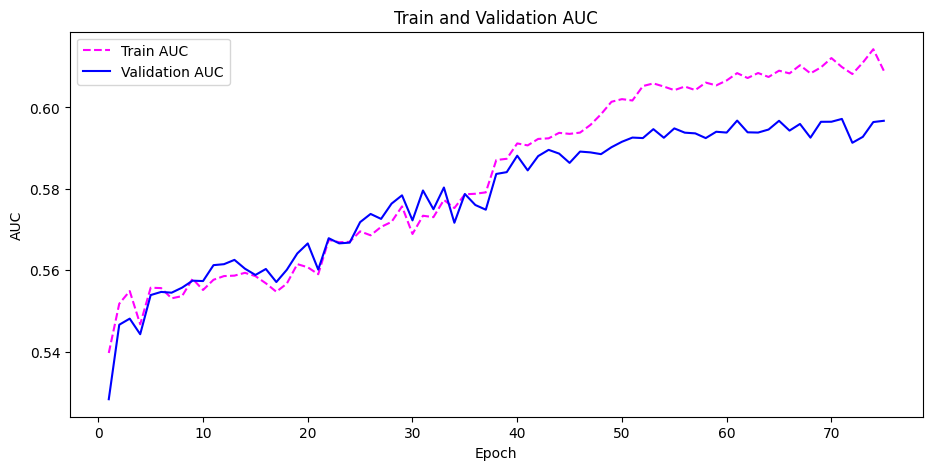

In [59]:
# Display a AUC plot over the epochs for both the training and validation data
accuracy_results.display_auc_plot()

Using the **LeakyReLU** activation seemed to help the jittery line of the last model. The validation plot is closer to the training data plot. The loss plot shows the validation data was close until the end where it started to diverge.

203/203 [==============================] - 1s 4ms/step


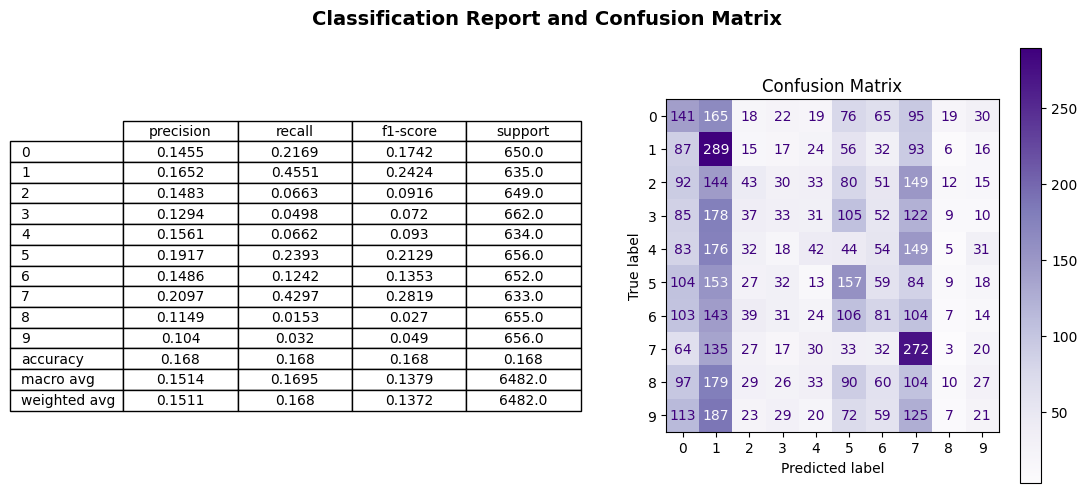

In [92]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(basic_cnn_model_with_regularization_lr.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [93]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("basic_cnn_reg_lr", accuracy_value, basic_cnn_model_with_regularization_lr.model)

This classification report shows an improvement as well. The precision and recall are improved (although recall lags behind a bit). The F1 score is again a bit low. The confusion matrix is also an improvement over the previous but still shows some bias.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Basic GRU with Regularization:</span>

This will be the first departure from using a CNN. I chose to go with a gated recurrent unit (**GRU**) as its less complex than the LSTM so it has less parameters. Because the data is time dependent (readings are done over time), perhaps a RNN model can uncover a pattern in the data that the CNN missed. This is my assumption anyway.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

I am using one GRU layer followed by layer normalization. I then use one dense layer also with layer normalization. The output layer is the same as was used in the previous CNN models. I chose to stick with the LeakyReLU used in the past model because it appeared to have a positive effect.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

This model will use relatively few GRU units (32) and few dense layer units (16). I'm also sticking with the same L2 regularization as the previous model to help with any overfitting that might occur.

In [62]:
class GRUModel(AbstractBaseModel):
    """
    A basic RNN model
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(GRU(32, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), kernel_regularizer=regularizers.L2(1e-3), input_shape=self.X_training.shape[1:]))
        model.add(LayerNormalization())
        
        model.add(Dense(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+2)))
        model.add(LayerNormalization())
        model.add(LeakyReLU())
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(1e-3), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [63]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
gru_model = GRUModel(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 50, 32, 10)
gru_model.fit_model()

Epoch 1/50
1621/1621 [==============================] - 109s 66ms/step - loss: 2.3269 - accuracy: 0.1000 - val_loss: 2.3183 - val_accuracy: 0.0994 - lr: 0.0010 - auc: 0.5109 - val_auc: 0.5035
Epoch 2/50
1621/1621 [==============================] - 100s 62ms/step - loss: 2.3113 - accuracy: 0.1017 - val_loss: 2.3110 - val_accuracy: 0.0994 - lr: 0.0010 - auc: 0.5141 - val_auc: 0.5014
Epoch 3/50
1621/1621 [==============================] - 103s 64ms/step - loss: 2.3080 - accuracy: 0.1002 - val_loss: 2.3075 - val_accuracy: 0.1018 - lr: 0.0010 - auc: 0.5132 - val_auc: 0.5001
Epoch 4/50
1621/1621 [==============================] - 104s 64ms/step - loss: 2.3064 - accuracy: 0.0984 - val_loss: 2.3062 - val_accuracy: 0.0977 - lr: 0.0010 - auc: 0.5137 - val_auc: 0.5033
Epoch 5/50
1621/1621 [==============================] - 106s 66ms/step - loss: 2.3053 - accuracy: 0.1025 - val_loss: 2.3051 - val_accuracy: 0.1001 - lr: 0.0010 - auc: 0.5134 - val_auc: 0.5034
Epoch 6/50
1621/1621 [==================

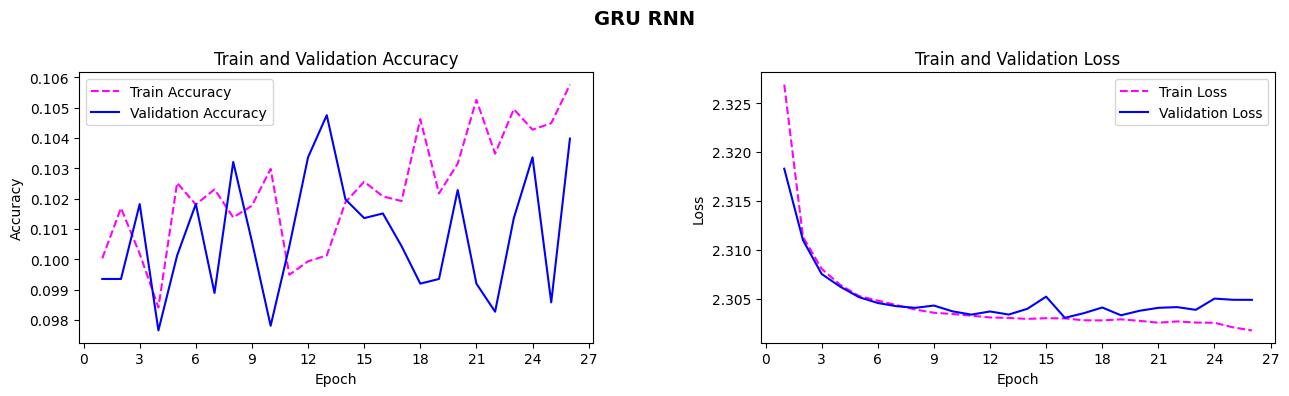

In [64]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(gru_model, "GRU RNN")
accuracy_results.display_accuracy_plots()

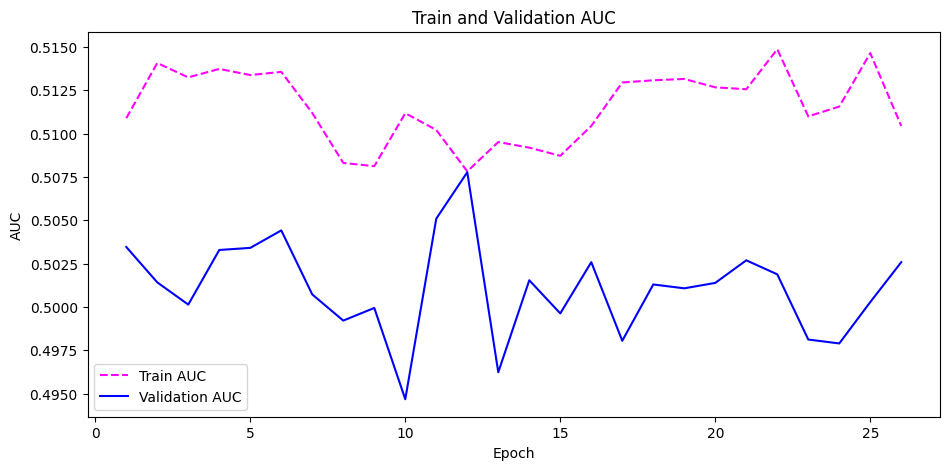

In [65]:
# Display a AUC plot over the epochs for both the training and validation data
accuracy_results.display_auc_plot()

This model didn't seem to perform better than randomly guessing (given 10 possible outcomes, a value of 0.10 would be expected). This is a bit surprising as I thought there would be clear temporal patterns. Not only did the model under perform with the validation data, it also under performed learning anything with the training data. Perhaps in terms of temporal data, there isn't much meaning in it.

203/203 [==============================] - 4s 21ms/step


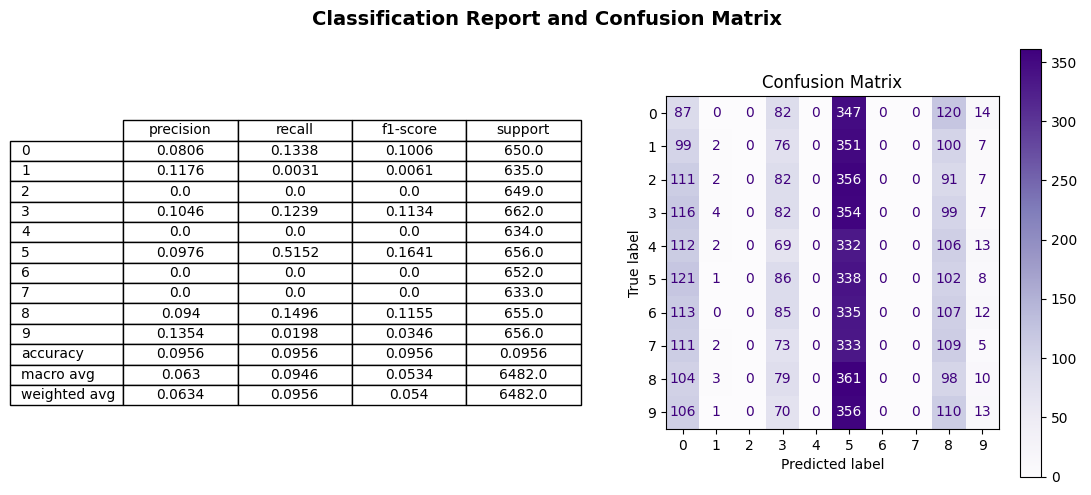

In [94]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(gru_model.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [95]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("gru", accuracy_value, gru_model.model)

The classification report and confusion matrix are on par with the performance reported by the accuracy plot. That is, nothing substantial other than elevated elements of bias. The confusion matrix is also indicating bad precision and recall.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Bidirectional GRU with Regularization:</span>

The previous GRU model's performance was underwhelming to say the least. Perhaps processing the sequence in both directions might help uncover some hidden latent patterns. For this model I will add a bidirectional element to it.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

This model's architecture remains the same as the previous with exception of the additional of the bidirectional element.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Even though the sequences of data will be processed in both directions, I chose not to increase the L2 regularization. My thought here is that the previous model performed so poorly that I'm OK if this model overfits the training data a bit. I want to give it as much encouragement to find a pattern, even if some of it is from memorizing the training data.

In [68]:
class BidirectionalGRUModel(AbstractBaseModel):
    """
    A simple bidirectional RNN.
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(Bidirectional(GRU(32, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), kernel_regularizer=regularizers.L2(1e-3), input_shape=self.X_training.shape[1:])))
        model.add(LayerNormalization())
        
        model.add(Dense(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+2)))
        model.add(LayerNormalization())
        model.add(LeakyReLU())
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(1e-3), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [69]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
bidirectional_gru_model = BidirectionalGRUModel(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 50, 32, 10)
bidirectional_gru_model.fit_model()

Epoch 1/50
1621/1621 [==============================] - 131s 80ms/step - loss: 2.3339 - accuracy: 0.1000 - val_loss: 2.3193 - val_accuracy: 0.1017 - lr: 0.0010 - auc: 0.5129 - val_auc: 0.5016
Epoch 2/50
1621/1621 [==============================] - 42s 26ms/step - loss: 2.3123 - accuracy: 0.1038 - val_loss: 2.3108 - val_accuracy: 0.1007 - lr: 0.0010 - auc: 0.5133 - val_auc: 0.4997
Epoch 3/50
1621/1621 [==============================] - 51s 31ms/step - loss: 2.3084 - accuracy: 0.1021 - val_loss: 2.3078 - val_accuracy: 0.0987 - lr: 0.0010 - auc: 0.5123 - val_auc: 0.5046
Epoch 4/50
1621/1621 [==============================] - 44s 27ms/step - loss: 2.3066 - accuracy: 0.0998 - val_loss: 2.3065 - val_accuracy: 0.0989 - lr: 0.0010 - auc: 0.5122 - val_auc: 0.4971
Epoch 5/50
1621/1621 [==============================] - 42s 26ms/step - loss: 2.3052 - accuracy: 0.1025 - val_loss: 2.3055 - val_accuracy: 0.1044 - lr: 0.0010 - auc: 0.5111 - val_auc: 0.4977
Epoch 6/50
1621/1621 [======================

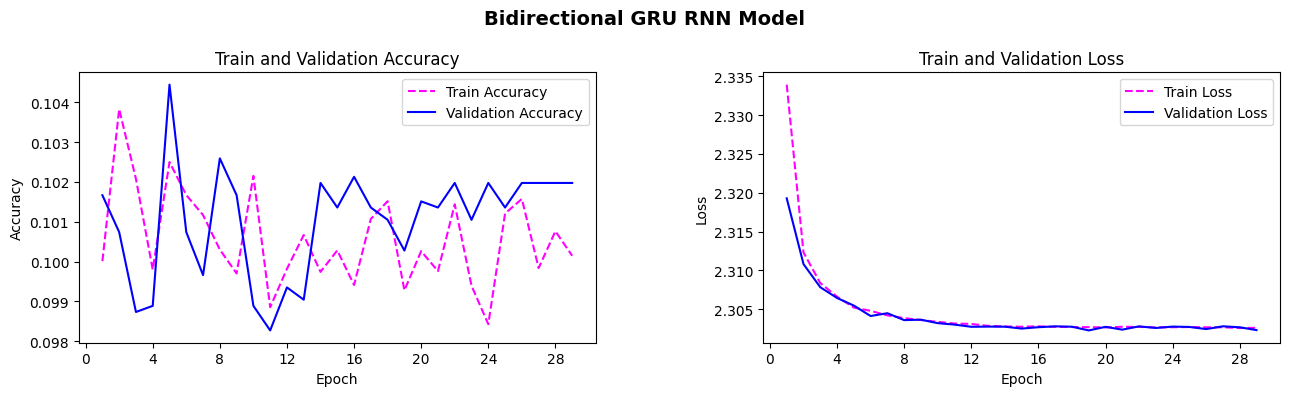

In [70]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(bidirectional_gru_model, "Bidirectional GRU RNN Model")
accuracy_results.display_accuracy_plots()

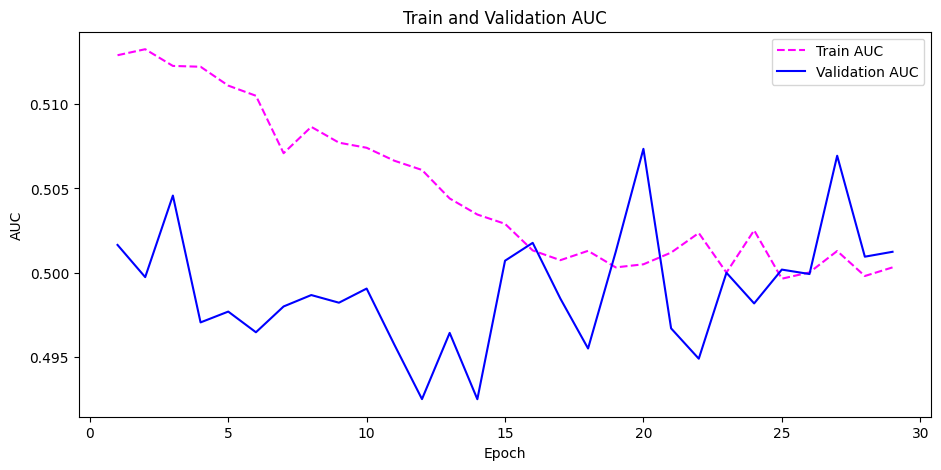

In [71]:
# Display a AUC plot over the epochs for both the training and validation data.
accuracy_results.display_auc_plot()

Using the bidirectional element with the GRU didn't seem to help, and training time was substantially longer. Perhaps there really isn't any latent features to be uncovered (or at least not prevalent enough to be found with a "simple" RNN). While both curves showed the validation data matched the training data shape, it's not of much interest as the model didn't perform much better than randomly guessing.

203/203 [==============================] - 8s 41ms/step


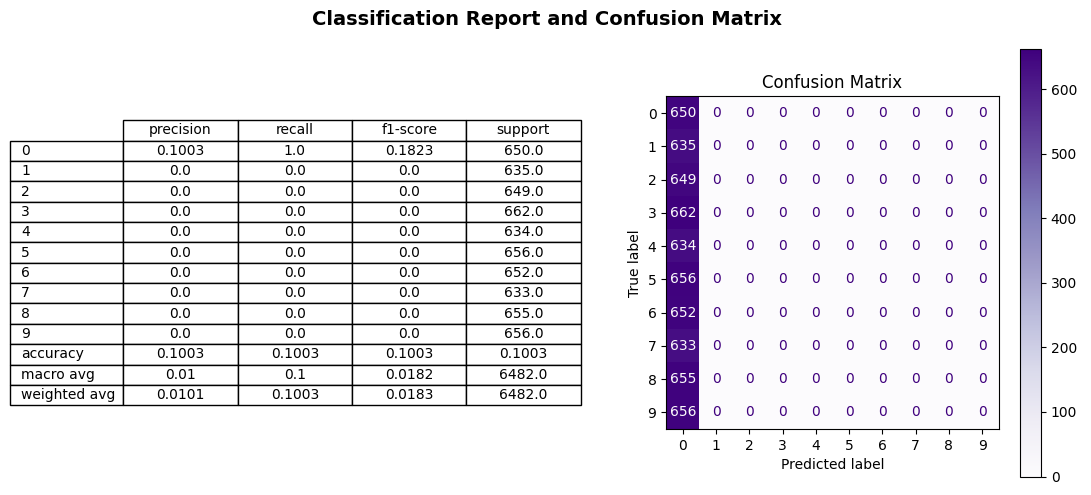

In [96]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(bidirectional_gru_model.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [97]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("bidirectional_gru", accuracy_value, bidirectional_gru_model.model)

Since the model performed so poorly, there is little analysis needed for the classification report and confusion matrix. Again the confusion matrix showed its usual bias. This is indicating bad precision and recall with this model.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Large CNN with Regularization:</span>

From what we learned from the previous models, the CNN seemed to perform the best. So for this model I will stick with the basic CNN design but increase the complexity significantly in an attempt to further improve performance.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

For this model I will substantially increase the complexity in both the convolutional layers as well as the dense layers. This model will have three convolutional layers, each with batch normalization and a max pooling layer. I am again sticking with the LeakyReLU activation, as that showed promise early on. For this model, because of the increase in size, I will introduce dropout layers to combat the possibility of overfitting.

After flattening the CNN layers, I am using three dense layers (not including the output layer). Similar to the CNN portion, these layers all use batch normalization, the LeakyReLU activation, and dropout.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

This model is going to be much larger than the previous. The first convolutional layer will use 64 filters, the second will double this to 128, and the third will double that to 256 filters. The first convolutional layer will use a larger kernel size of 5, then be reduced to 3 for the following layers.

Once the CNN portion is flattened, it will feed into a 128 unit dense layer. This will be doubled to 256 for the second dense layer and then reduced to 128 unit for the final dense layer before the output layer. I chose to reduce the L2 regularization a bit to offset the addition of the dropout layers.

In [74]:
class LargeCNNModelWithRegularization(AbstractBaseModel):
    """
    Large CNN model with multiple convolutional layers and dense layers. Includes supporting layers (e.g. max pooling).
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        
        model.add(Conv1D(64, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), kernel_regularizer=regularizers.L2(1e-4), kernel_size=5, padding='same', input_shape=self.X_training.shape[1:]))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        
        model.add(Conv1D(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-4), kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.1))

        model.add(Conv1D(256, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(1e-4), kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        
        model.add(Flatten())

        model.add(Dense(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+4), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(256, kernel_initializer=Orthogonal(seed=SEED_VALUE+5), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+6), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+7), kernel_regularizer=regularizers.L2(1e-4), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [75]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
large_cnn_model = LargeCNNModelWithRegularization(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 100, 32, 10)
large_cnn_model.fit_model()

Epoch 1/100
1621/1621 [==============================] - 19s 11ms/step - loss: 2.4039 - accuracy: 0.1135 - val_loss: 2.3587 - val_accuracy: 0.1248 - lr: 0.0010 - auc: 0.5437 - val_auc: 0.5416
Epoch 2/100
1621/1621 [==============================] - 46s 29ms/step - loss: 2.3447 - accuracy: 0.1305 - val_loss: 2.3298 - val_accuracy: 0.1280 - lr: 0.0010 - auc: 0.5451 - val_auc: 0.5457
Epoch 3/100
1621/1621 [==============================] - 47s 29ms/step - loss: 2.3224 - accuracy: 0.1346 - val_loss: 2.3263 - val_accuracy: 0.1271 - lr: 0.0010 - auc: 0.5463 - val_auc: 0.5460
Epoch 4/100
1621/1621 [==============================] - 47s 29ms/step - loss: 2.3166 - accuracy: 0.1326 - val_loss: 2.3113 - val_accuracy: 0.1364 - lr: 0.0010 - auc: 0.5523 - val_auc: 0.5480
Epoch 5/100
1621/1621 [==============================] - 47s 29ms/step - loss: 2.3103 - accuracy: 0.1334 - val_loss: 2.3107 - val_accuracy: 0.1385 - lr: 0.0010 - auc: 0.5516 - val_auc: 0.5521
Epoch 6/100
1621/1621 [=================

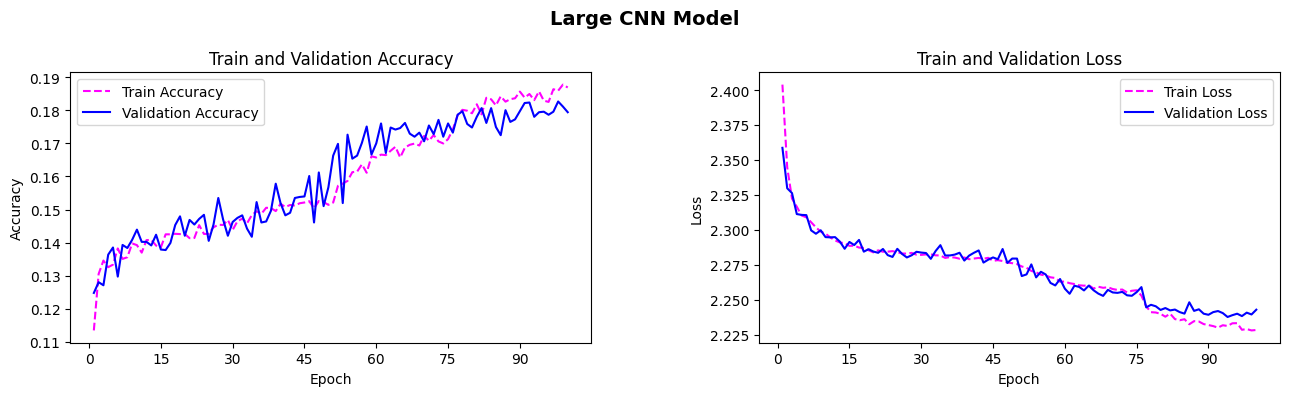

In [76]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(large_cnn_model, "Large CNN Model")
accuracy_results.display_accuracy_plots()

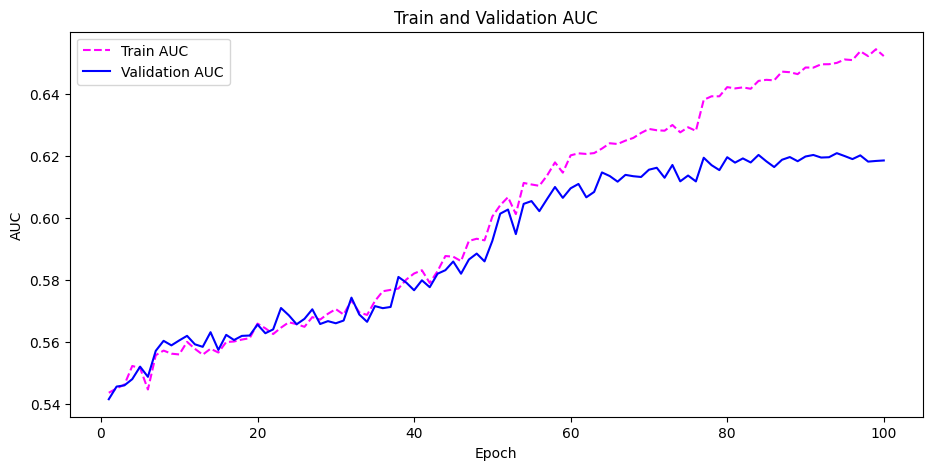

In [77]:
# Display a AUC plot over the epochs for both the training and validation data.
accuracy_results.display_auc_plot()

This model has performed the best yet. The validation accuracy was less jittery and followed the training accuracy much better. Same with the loss plot.

203/203 [==============================] - 1s 5ms/step


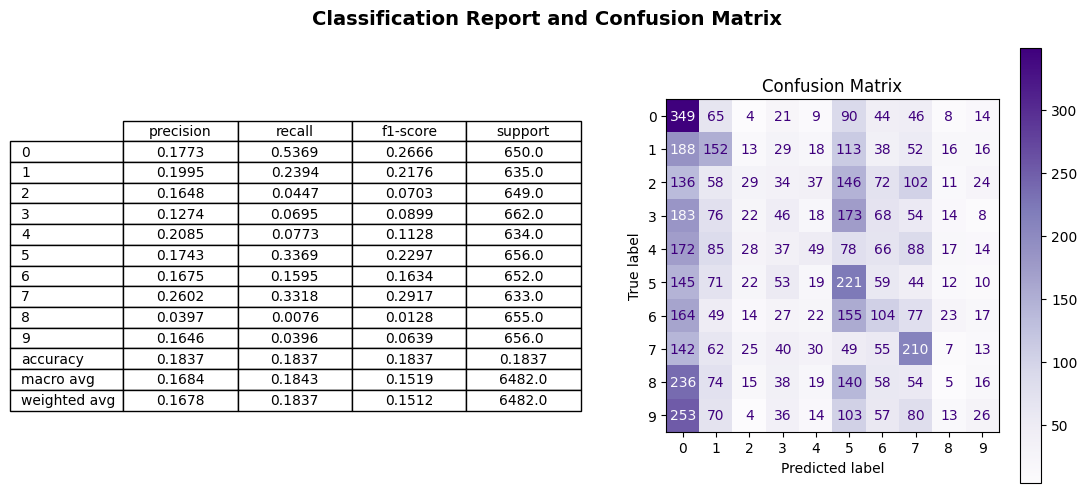

In [98]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(large_cnn_model.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [99]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("large_cnn", accuracy_value, large_cnn_model.model)

In the classification report the precision and recall were much better. The F1-score is pretty good for some of the classes. We can see the diagonal pattern emerging on the confusion matrix.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Large Hybrid Model with Regularization:</span>

Lastly I want to try combining both a CNN and an RNN. From the previous tests, the RNNs did not perform well, but perhaps using an RNN with a CNN might change things.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

For this model, I will keep with the same basic architecture as the previous model but switch out the flattening layer with a bidirectional GRU. Again, all layers will use batch normalization (or layer normalization for the GRU). I will keep using both L2 and dropout regularization.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

The same hyperparameters will be used for the CNN portion. 64 filters increasing to 256. 

For the bidirectional GRU layer, I chose to reduce the number of units to 16 with the idea that it's positive influence will outweigh any negative influence. From the previous tests, the use of an RNN didn't have any affect so I want to limit its use here.

Finally for the dense layers, I again started with 128 units and doubled to 256 before going into the standard output layer.

In [80]:
class LargeHybridModelWithRegularization(AbstractBaseModel):
    """
    Large CNN-RNN hybrid model with supporting layers (e.g. max pooling)
    """
    def __init__(self, X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience):
        super().__init__(X_training, y_training, X_validation, y_validation, max_epochs, batch_size, early_stopping_patience)

    # Override
    def build_model(self):
        model = Sequential()
        model.add(Conv1D(64, kernel_initializer=Orthogonal(seed=SEED_VALUE+1), kernel_regularizer=regularizers.L2(1e-4), kernel_size=5, padding='same', input_shape=self.X_training.shape[1:]))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        
        model.add(Conv1D(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-4), kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.1))

        model.add(Conv1D(256, kernel_initializer=Orthogonal(seed=SEED_VALUE+3), kernel_regularizer=regularizers.L2(1e-4), kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPooling1D())
        model.add(Dropout(0.1))
        
        model.add(Bidirectional(GRU(16, kernel_initializer=Orthogonal(seed=SEED_VALUE+4), kernel_regularizer=regularizers.L2(1e-4))))
        model.add(LayerNormalization())
        
        model.add(Dense(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+4), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(256, kernel_initializer=Orthogonal(seed=SEED_VALUE+5), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(128, kernel_initializer=Orthogonal(seed=SEED_VALUE+6), kernel_regularizer=regularizers.L2(1e-4)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        
        model.add(Dense(10, kernel_initializer=Orthogonal(seed=SEED_VALUE+7), kernel_regularizer=regularizers.L2(1e-4), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [81]:
# Clear the session and fit the model.
tf.keras.backend.clear_session()
hybrid_model = LargeHybridModelWithRegularization(np.transpose(X_train_std,(0,2,1)), y_train, np.transpose(X_val_std, (0,2,1)), y_val, 100, 32, 15)
hybrid_model.fit_model()

Epoch 1/100
1621/1621 [==============================] - 91s 55ms/step - loss: 2.4206 - accuracy: 0.1024 - val_loss: 2.3802 - val_accuracy: 0.1024 - lr: 0.0010 - auc: 0.5083 - val_auc: 0.5000
Epoch 2/100
1621/1621 [==============================] - 69s 43ms/step - loss: 2.3705 - accuracy: 0.0988 - val_loss: 2.3633 - val_accuracy: 0.0995 - lr: 0.0010 - auc: 0.5101 - val_auc: 0.5004
Epoch 3/100
1621/1621 [==============================] - 82s 50ms/step - loss: 2.3423 - accuracy: 0.1024 - val_loss: 2.3287 - val_accuracy: 0.1043 - lr: 0.0010 - auc: 0.5091 - val_auc: 0.5082
Epoch 4/100
1621/1621 [==============================] - 91s 56ms/step - loss: 2.3268 - accuracy: 0.1043 - val_loss: 2.3220 - val_accuracy: 0.1080 - lr: 0.0010 - auc: 0.5099 - val_auc: 0.5129
Epoch 5/100
1621/1621 [==============================] - 90s 55ms/step - loss: 2.3188 - accuracy: 0.1065 - val_loss: 2.3160 - val_accuracy: 0.1072 - lr: 0.0010 - auc: 0.5208 - val_auc: 0.5147
Epoch 6/100
1621/1621 [=================

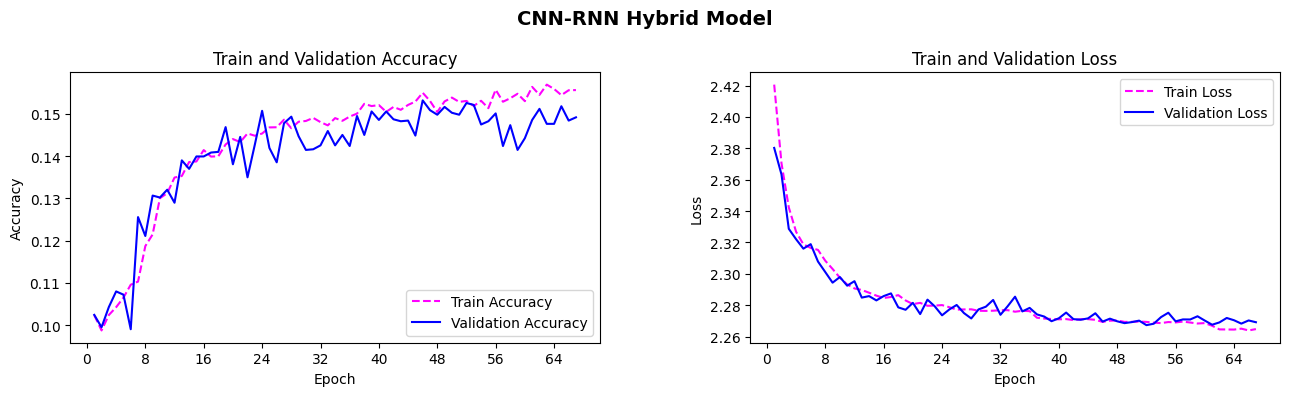

In [82]:
# Display the accuracy and loss plot over the epochs for both the training and validation data.
accuracy_results = AccuracyResults(hybrid_model, "CNN-RNN Hybrid Model")
accuracy_results.display_accuracy_plots()

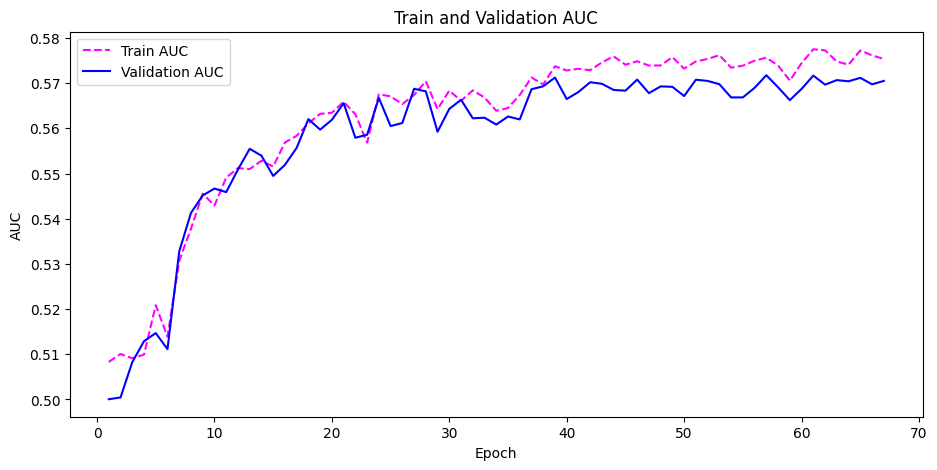

In [83]:
# Display a AUC plot over the epochs for both the training and validation data.
accuracy_results.display_auc_plot()

It's hard to say if the addition of the GRU layer helped the CNN. Given the bidirectional GRU alone did not perform well, I think it might not have helped much here. This is something that could use further investigation.

203/203 [==============================] - 2s 12ms/step


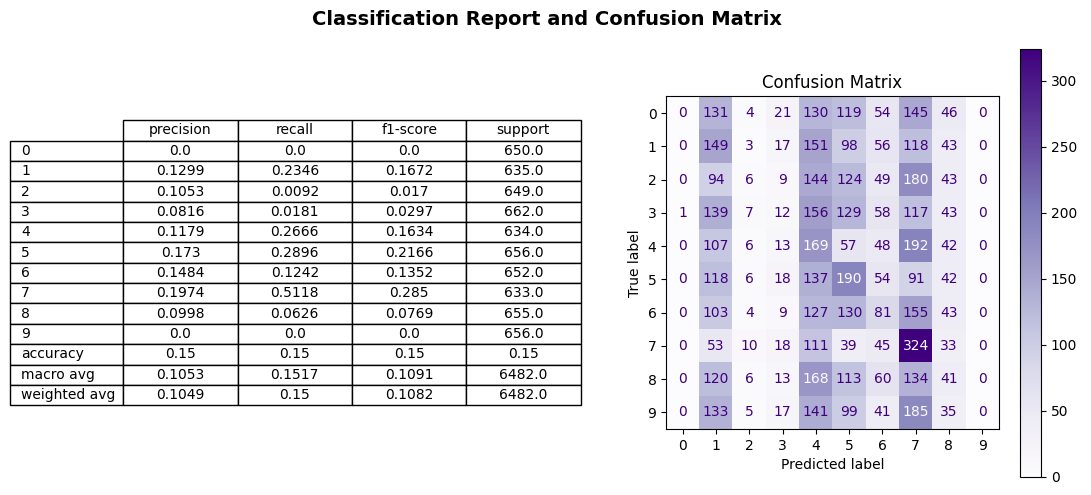

In [100]:
# Display a classification report and confusion matrix
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(hybrid_model.model, y_test)
accuracy_value = classification_and_confusion_matrix_manager.display()

In [101]:
# Store test accuracy and AUC data for this model.
test_accuracy_and_auc_plot_manager.add_record("large_hybrid", accuracy_value, hybrid_model.model)

Following the underwhelming accuracy performance, the classification report and confusion matrix was as expected. There is little to report here as it is on par with what we saw when using the GRU and bidirectional GRU alone.

## <span style="color: royalblue;">Results Summary</span>

Below are plots of the accuracy and AUC values for the various models that were tested and tuned.

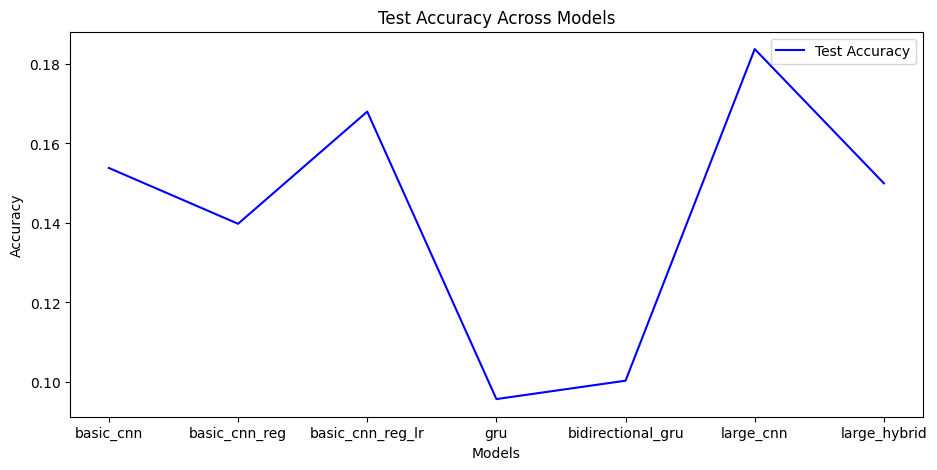

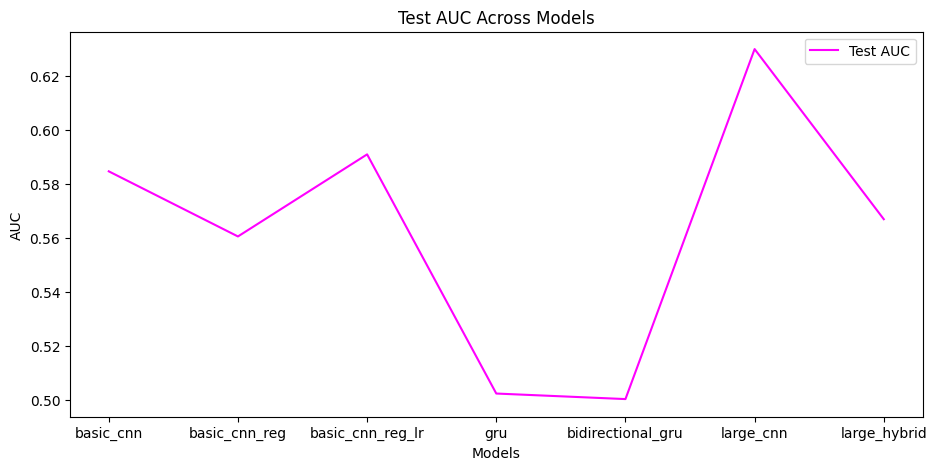

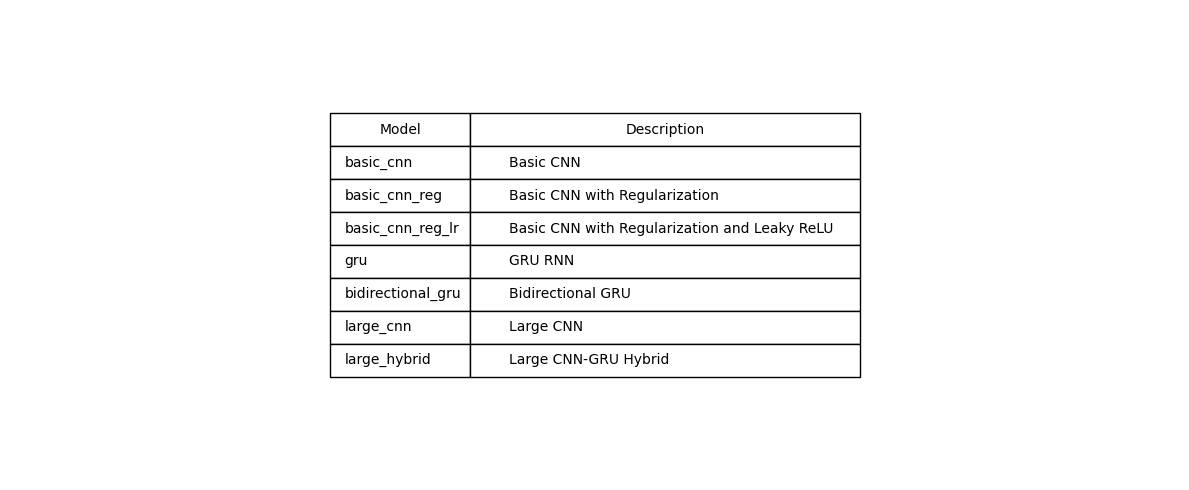

In [102]:
test_accuracy_and_auc_plot_manager.display_accuracy_plot()
test_accuracy_and_auc_plot_manager.display_auc_plot()
test_accuracy_and_auc_plot_manager.display_legend()

From the above test accuracy and AUC plots, we can see the CNN models performed the best. It does make sense that a CNN model would perform well for EEG data as there is spatial information in the data. That is, the order of the values in the amplitude data is important.

The data appears to have benefitted from a more complex model, as the accuracy and AUC values improved with the added layers.

Most surprising is that the RNN models didn't perform well individually. Using a combination of a CNN and a bidirectional GRU did show an improvement over the RNN models alone, but did not perform as well as the large CNN alone.

The AUC value went a bit above 0.6 with the large CNN model, indicating the model is indeed predicting classifications significantly beyond what is considered random.

## <span style="color: royalblue;">Summary, Discussion, and Conclusion</span>

I started out getting a feel for the dataset. First I converted the data from the provided CSV file into a more usable Pandas data frame. This has a number of benefits, including easy filtering and manipulation. We saw the size of the dataset, the number of channels, and the time-dependent EEG data. We saw that there was a variable number of readings across the different events.

Next, I moved onto **exploratory data analysis (EDA) and data cleaning**. Here I started out with plotting a histogram of the number of timesteps for all the events. This showed that the majority of events were between 250 and 275 readings. From the data source site, we saw that the readings were taken at a rate of 128 per second. As noted in the site, the intent was to show the subject a number and have him think about it for 2 seconds. Because of this, I decided to "cut off" the readings to be at or below 264 to allow for a little spill over but be close to the intended 256 readings. I didn't want to use the max value of timesteps present in the data as this was too sparse and would likely affect how the model learns the data.

I verified that all the events had the same number of channels. For this data, the EPOC-X 14 channel EEG headset was used, so I wanted to make sure all the events have 14 channels in the data. 

I used a pie chart and bar chart to display the distribution of the class labels. From this, we saw that there was a **-1** label. From the dataset site: **"-1 for random captured signals not related to any of the digits."** For this project I decided that I won't need that data, so any events with this class label were removed.

I checked for the presence of duplicates across the events and found a few. The number was relatively small so I decided to remove them. Given the noisy nature of the data, I wanted to give the models the best chance to learn meaningful patterns and to not overfit the data. Removing duplicate data will help the model not to overfit the data. Of course, this alone won't be enough, but it will certainly help.

I checked the total number of missing data (as represented by **NaN** values) and saw there was quite a bit of missing data. This is expected as the total number of rows in the dataset was approaching 1 million. This wasn't a huge concern as after standardization these missing values would be given a neutral value. Also neural networks, such as CNNs, can learn to "ignore" certain data.

Before starting on building out the models that would train on the data, I first converted the data into a format that is more suitable to be used with the Keras libraries being used. I first converted the one data frame into two separate Numpy matrices, one for the X data and one for the y data. There was no validation or training data explicitly provided, so I split the given data into three sets: the training set, the validation set, and the test set.

I then standardized the data. I did this by centering the data around 0 and scaling it to have a standard deviation of 1 (unit variance). This was done with the training data alone. I used the training data statistics to apply the standardization to the validation and the test sets.

Lastly, I plotted an example of the 14-channel data before and after the standardization to get a visualization of the data that will used with the models. It was easy to see that the data is very noisy and likely will present a challenge for the neural networks to learn.

Now that the data has been analyzed and cleaned, I moved onto the model-building portion of the project. From my research, convolutional neural networks (CNNs) and recurrent neural networks (RNNs) appear to be the best choices for the EEG data in this project. In my research, it was noted that EEG data is similar in structure to that of audio and image data, both of which work well with CNNs. To put it simply, if restructuring data removes it's meaning, it is likely to work well with CNNs. Also because of the time dependent nature of the data (it was recorded for roughly 2 seconds) a RNN also seems like a good fit (an assumption that didn't pan out well).

To start the model building and training, I wanted to start with a small set of models to see how they are affected by the data. I started out with a very small and simple CNN, and then added regularization (L2), and finally switching the activation from a "standard" ReLU to a Leaky ReLU. This change seemed be a good idea given how the data was standardized (it included both positive and negative values) as a standard ReLU would eliminate the negative value's contribution. The basic CNN models did pick up patterns in the EEG data and were able to generalize to unseen data.

Moving onto a couple simple RNN models, I kept with using L2 regularization, layer normalization (similar to the batch normalization), and the Leaky ReLU activation that appeared to have a positive effect with the CNN models. Surprisingly, the RNN models did not seem to work well with this data as the accuracy and AUC values appeared to hover right around what one would expect with just randomly guessing. I was a bit disappointed with this, as I thought this data would lend itself nicely to a time-dependent models.

From what I learned from the smaller CNN models, I moved onto using a more complex CNN model utilizing multiple convolutional layers complete with the supporting layers (e.g. max pooling and batch normalization). I also added dropout layers to further help with regularization, as larger models have a tendency to overfit data. This isn't surprising here as even the smaller models used showed some overfitting. I added multiple dense layers and included dropout layers there as well. Because of the added dropout layers, I decided to reduce the amount of L2 regularization so the model wouldn't take too long to train. From research and previous projects I found there is such a thing as too much regularization. This larger CNN model turned out to perform the best out of all the models.

Not wanting to give up on using RNNs with this data, I decided to try out combining a CNN with an RNN for a hybrid model. My thought with this was that, even though the RNN models alone didn't work out well, perhaps in combination with a CNN model that did work well, that it might then uncover latent time dependent information. While this hybrid model performed better than the RNN models did alone, it never reached the level of the large CNN model. This is something that could use further investigation, as I don't think an RNN should be abandoned.

As I mentioned in the introduction, EEG data is noisy and the signals were likely subtle. Because of this, I knew it would be challenging to find meaningful patterns in the data. That said, I was happy with how the CNN models performed. From the AUC plots it was clear the models were able to generalize and predict class labels that were statistically significant.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What worked well?</span>
* The data analysis, EDA, and data cleanup proved once again to be an important step when working with a new dataset. It is always a good idea to get a sense of the data before jumping into build the models. As we saw here, the data did need to be organized and cleaned up before being used with any deep-learning models.
* Starting with smaller models to get a sense on how they are affected by architectural and hyperparameter tuning changes. Using the knowledge gained here made creating more complex models easier, as it was based on informed decisions.
* The various plots (accuracy, loss, AUC, classification reports, confusion matrices, etc.) helped greatly to get a sense of what things looked like an how models performed.
* The CNN architecture worked quite well with the EEG data.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What could be improved? What next?</span>
* As I mentioned throughout this project, the RNN architecture did not work well and that I was surprised by that. From my initial research, this seemed like a promising approach. Models with RNN aspects took the longest to train so I thought that might translate into good predictive performance. Perhaps the RNN model was too simple? Maybe a more complex design would yield better results.
* The larger CNN model worked the best in this project. Exploring this might improve results even more.
* As mentioned previously, the data was collected from one subject. It would be interesting to see a larger study with more participants. It's quite possible subjects think in different ways, and it's possible brains of different people process information in different ways. A larger study with more participants could yield much better data.
* I mentioned that I chose the data collected from the 14-channel EPOC-X EEG headset. There were 4 datasets available with differing number of channels. Perhaps some of the channels used do not add meaningful data and possibly make it more difficult for the models to learn. Also, perhaps combining the different datasets would yield better results? This seems like something worth investigating.
* From the results of the hybrid CNN-GRU approach, I think this could be looked into further.
* Lastly given the noisy and subtle nature of EEG data, perhaps even more pre-processing (e.g. FFT) would help the models uncover more meaningly deeper latent patterns.

## <span style="color: royalblue;">Resources</span>
* https://www.emotiv.com/products/epoc-x
* https://www.kuow.org/stories/brain-technology-is-moving-forward-but-are-ethical-standards-up-to-speed
* https://mindbigdata.com/opendb/index.html
* https://towardsdatascience.com/convolutional-neural-networks-for-eeg-brain-computer-interfaces-9ee9f3dd2b81/
* https://medium.com/intuition/deep-recurrent-neural-networks-for-electroencephalography-analysis-7c428c50f038
* https://keras.io/api/layers/convolution_layers/convolution1d/
* https://keras.io/api/layers/recurrent_layers/gru/
* https://keras.io/api/layers/recurrent_layers/bidirectional/
* https://keras.io/api/layers/normalization_layers/layer_normalization/
* https://keras.io/api/layers/normalization_layers/batch_normalization/